# Formation RNAseq CEA - juin 2023

*Enseignantes : Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

R version 4.2.3

# Part 9: Normalisation and Differential Expression analysis with DESeq2 

- 0. 1 - Setting up this R session on IFB core cluster  
- 0. 2 - Parameters to be set or modified by the user   
- 1 - Loading input data: countdata, metadata and gene info
- 2 - Modeling count distribution for each gene with `DESeq()`
- 3 - Normalisation of count distribution with `rlog` and `vst`
- 4 - Differential expression analysis with `DESeq2`
- 5 - Visualisation of the DE analysis results with volcano plots
- 6 - Saving our results for later use : Genes lists and RData file

---
---
## 0 - Getting started
---

### 0.1 - Setting up this R session on IFB core cluster

<em>loaded JupyterLab</em> : Version 3.5.0

In [1]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/sys/dash {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,ReqMem,NodeList,Elapsed,State -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Sat Jun 22 21:07:48 CEST 2024 ==="                         
[2] "          40326379      fast sys/dash scaburet  R    2:42:28      1 cpu-node-51"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                         
[4] "JobID         AllocCPUS     ReqMem        NodeList    Elapsed      State "      
[5] "------------ ---------- ---------- --------------- ---------- ---------- "      
[6] "40326379              7        33G     cpu-node-51   02:42:28    RUNNING "      


__

Next we load into this R session the various tools that we will use.   
If a R 4.2 library folder is not already included in the available libPaths, Code cell 2 will add it. This way, required packages that are not already present on the server will be installed in your home.

In [2]:
## Code cell 2 ##

# verification of the paths to the R librairies
.libPaths()

# creation of the directory if it was not created in previous analyses, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create("~/R/x86_64-conda-linux-gnu-library/4.2", recursive = TRUE, showWarnings = FALSE)

# in the case your home directory is not in libPaths
.libPaths('~/R/x86_64-conda-linux-gnu-library/4.2')

# verification of its addition:
.libPaths()

[1] "/shared/ifbstor1/home/scaburet/R/x86_64-conda-linux-gnu-library/4.2"
[2] "/shared/ifbstor1/software/miniconda/envs/r-4.2.3/lib/R/library"

[1] "/shared/ifbstor1/home/scaburet/R/x86_64-conda-linux-gnu-library/4.2"
[2] "/shared/ifbstor1/software/miniconda/envs/r-4.2.3/lib/R/library"

***DO NOT worry*** if you see a large red output!! It contains only a warning message, including for functions from different packages sharing the same names.

In [3]:
## Code cell 3 ##

# list the required libraries from the CRAN repository
requiredLib <- c(
     "tidyverse",
    "magrittr",
    "matrixStats",
    "BiocManager",
    "ggplot2"
)

# list the required libraries from the Bioconductor project
requiredBiocLib <- c("DESeq2", "vsn")

# install required libraries if not yet installed
for (lib in requiredLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
    install.packages(lib, quiet = TRUE)
  }
}

for( lib in requiredBiocLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
  BiocManager::install(lib, quiet = TRUE)
  }
}

# load libraries
message("Loading required libraries")
for (lib in requiredLib) {
  library(lib, character.only = TRUE)}
for (lib in requiredBiocLib) {
  library(lib, character.only = TRUE)}

# remove variables from the R session if they are no longer necessary 
rm(lib, requiredLib, requiredBiocLib)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count


Bioconductor version '3.16' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install


Attaching package: 'BiocGenerics'


The followin

In [4]:
## Code cell 4 ##   

cat("Here is my R session with the loaded packages:\n")
sessionInfo()

Here is my R session with the loaded packages:


R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.2.3/lib/libopenblasp-r0.3.21.so

locale:
[1] C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] vsn_3.66.0                  DESeq2_1.38.3              
 [3] SummarizedExperiment_1.28.0 Biobase_2.62.0             
 [5] MatrixGenerics_1.10.0       GenomicRanges_1.50.2       
 [7] GenomeInfoDb_1.34.9         IRanges_2.32.0             
 [9] S4Vectors_0.36.2            BiocGenerics_0.44.0        
[11] BiocManager_1.30.23         matrixStats_1.3.0          
[13] magrittr_2.0.3              lubridate_1.9.3            
[15] forcats_1.0.0               stringr_1.5.1              
[17] dplyr_1.1.4                 purrr_1.0.2                
[19] readr_2.1.5                 tidyr_1.3.1                
[21] tibble_

---
### 0.2 - Parameters to be set or modified by the user
---


- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

<div class="alert alert-block alert-warning"> <b> Warning on working directory: </b><br>In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened for the <b> first time </b>. Even if you move it to another directory, it keeps the original working directory unless you set it again with the function <code>setwd()</code>.</div>

In [5]:
## Code cell 5 ##

gohome <- "/shared/projects/2413_rnaseq_cea/"
gohome

myfolder <- getwd()
myfolder

[1] "/shared/projects/2413_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet"

- With a `/` at the end, define the path to the folder where the results of this analysis with `DESeq2` will be stored:

In [6]:
## Code cell 6 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste(myfolder,"/Results/deseq2/", sep = ""), recursive = TRUE)

# storing the path to this output folder in a variable
deseq2folder <- paste(myfolder,"/Results/deseq2/", sep = "")
deseq2folder

# listing the content of the folder
print(system(paste("ls -hlt", deseq2folder), intern = TRUE) )

Warning message in dir.create(paste(myfolder, "/Results/deseq2/", sep = ""), recursive = TRUE):
"'/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet/Results/deseq2' already exists"


[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet/Results/deseq2/"

[1] "total 13M"                                                                                  
[2] "-rw-rw----+ 1 scaburet scaburet 1.7M Jun 22 21:05 deseq2_all_genes.RData"                   
[3] "-rw-rw----+ 1 scaburet scaburet 4.6M Jun 22 21:05 deseq2.RData"                             
[4] "-rw-rw----+ 1 scaburet scaburet 2.4K Jun 22 21:05 DESeq2_significant_genes-0_00001-down.tsv"
[5] "-rw-rw----+ 1 scaburet scaburet 4.8K Jun 22 21:05 DESeq2_significant_genes-0_00001-up.tsv"  
[6] "-rw-rw----+ 1 scaburet scaburet 1.6M Jun 22 21:05 DESeq2_significant_genes-0_05.tsv"        
[7] "-rw-rw----+ 1 scaburet scaburet 4.6M Jun 22 20:52 deseq2-final.RData"                       


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [7]:
## Code cell 7 ##

options(repr.plot.width = 15, repr.plot.height = 8) # for figure display in the notebook

---
---
## 1 - Loading data
---

### 1.1 - Count data and metadata
---

First we need to retrieve the counts data and the metadata about samples. As we stored those in a global `.RData` object at the end of "Pipe_08", we can simply reload all our information by openig this .Rdata object. 

In [8]:
## Code cell 8 ##

pca1folder <- paste0(myfolder,"/Results/pca1/")
pca1folder
rdata <- paste0(pca1folder,"RawCounts_Samples.RData")
rdata
load(rdata,verbose = T)
rm(pca1folder) # not used any further

[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet/Results/pca1/"

[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet/Results/pca1/RawCounts_Samples.RData"

Loading objects:
  countdata
  samples
  conditionColor


We list all the objects we have currently in our session: 

In [9]:
## Code cell 9 ##

ls() 

[1] "conditionColor"     "countdata"          "deseq2folder"      
[4] "gohome"             "myfolder"           "rdata"             
[7] "samples"            "session_parameters"

We can now see it contains the two following dataframes:

- `countdata`: the dataframe containing all the read counts produced by `featureCounts` (as in the Pipe_06 notebook), ***on all 11 samples***, without the low counts genes.      
- `samples`:  the metadata dataframe containing the information about the samples, in particular the conditions of the experiment.

We will verify their content and structure.

***-> Let's start with the `samples` object containing the metadata.*** We see below it has 11 rows, one per sample.

In [10]:
## Code cell 10 ##

samples # since we have only 11 rows, we can easily print the whole file. We could aslo have used head(samples, n=11).
str(samples)

SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730405,dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730406,dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730407,dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730408,dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730409,dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805166,GSM4805166,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
SRR12730410,dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805167,GSM4805167,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
SRR12730411,dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805168,GSM4805168,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate3",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver


'data.frame':	11 obs. of  10 variables:
 $ SampleID           : chr  "SRR12730403" "SRR12730404" "SRR12730405" "SRR12730406" ...
 $ SampleName         : chr  "dHet_B-ALL_686_rep1" "dHet_B-ALL_686_rep2" "dHet_B-ALL_713_rep1" "dHet_B-ALL_713_rep2" ...
 $ Condition          : chr  "dHet" "dHet" "dHet" "dHet" ...
 $ Genotype           : chr  "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" ...
 $ GEO_Accession..exp.: chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ Sample.Name        : chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ source_name        : chr  "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate2" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate2" ...
 $ SRA.Study          : chr  "SRP

***-> We verify now that the raw `countdata` dataframe look like what we expect*** by checking the first rows and its structure. We see below it has 12 columns, one for Geneid and the other ones for each sample, while genes are present in rows.

In [11]:
## Code cell 11 ##

head(countdata)
str(countdata)

,Geneid,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
20,ENSMUSG00000025902.14,6,0,124,111,238,316,0,0,0,0,2
21,ENSMUSG00000104238.2,0,0,0,0,3,21,0,0,0,0,0
22,ENSMUSG00000102269.2,3,6,3,0,3,8,4,2,1,3,4
27,ENSMUSG00000098104.2,230,195,229,207,229,189,267,123,193,311,260
28,ENSMUSG00000102175.2,0,4,2,7,0,4,0,0,4,6,2
31,ENSMUSG00000103922.2,109,107,90,75,126,63,53,38,52,106,90


'data.frame':	24432 obs. of  12 variables:
 $ Geneid                   : chr  "ENSMUSG00000025902.14" "ENSMUSG00000104238.2" "ENSMUSG00000102269.2" "ENSMUSG00000098104.2" ...
 $ dHet_B-ALL_686_rep1      : int  6 0 3 230 0 109 15881 12 23 11308 ...
 $ dHet_B-ALL_686_rep2      : int  0 0 6 195 4 107 12310 10 17 8129 ...
 $ dHet_B-ALL_713_rep1      : int  124 0 3 229 2 90 6644 2 29 6226 ...
 $ dHet_B-ALL_713_rep2      : int  111 0 0 207 7 75 6996 14 40 6009 ...
 $ dHet_B-ALL_760_rep1      : int  238 3 3 229 0 126 13410 8 34 9010 ...
 $ dHet_B-ALL_760_rep2      : int  316 21 8 189 4 63 11089 6 36 7963 ...
 $ dHet_FetalLiver_proB_rep1: int  0 0 4 267 0 53 5838 4 0 7551 ...
 $ dHet_FetalLiver_proB_rep2: int  0 0 2 123 0 38 5227 6 2 6786 ...
 $ dHet_FetalLiver_proB_rep3: int  0 0 1 193 4 52 7622 11 12 6771 ...
 $ wt_BoneMar_proB_rep1     : int  0 0 3 311 6 106 7624 14 15 7825 ...
 $ wt_BoneMar_proB_rep2     : int  2 0 4 260 2 90 6216 6 0 7103 ...


-> ***Most importantly**, to ensure the **metadata `samples` and `countData` dataframes have the same sample names***, we run the code below. It tests for equality in the sample names in both dataframes, in the colnames of countdata (except column 1 for gene ids) and the column "SampleName" in samples. This will return TRUE for each name, if they are the same in both files. The `table()` function counts how many are equal. In all there are 11 samples in both files.

In [12]:
## Code cell 12 ##

table(colnames(countdata[,-1]) == samples$SampleName, useNA = "ifany")


TRUE 
  11 

### 1.2 - Annotation of genes in `gene_info`
---

In the above `countdata` dataframe, we can notice the genes are only indicated with their Ensembl GeneID (http://www.ensembl.org/Mus_musculus/Info/Index). It will thus be useful to obtain further information, including gene names or coordinates.

To do so we create a `genecode`dataframe from the Gencode annotation GTF file of the mouse genome. We have already downloaded it for all users of the project in `/shared/projects/2413_rnaseq_cea/alldata/Reference/` from this link: https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M35/gencode.vM35.annotation.gtf.gz. It can easily be done in bash with the `wget` command or its equivalent `wget()` fonction in R.

-> We now import the gtf file into R and look at its structure and the first rows.

In [13]:
## Code cell 13 ##

gencode <- read_tsv("/shared/projects/2413_rnaseq_cea/alldata/Reference/gencode.vM35.primary_assembly.annotation.gtf.gz",
                                     skip = 5, col_names = F, show_col_types = FALSE)


In [14]:
## Code cell 14 ##

str(gencode)
head(gencode)

spc_tbl_ [1,893,083 x 9] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ X1: chr [1:1893083] "chr1" "chr1" "chr1" "chr1" ...
 $ X2: chr [1:1893083] "HAVANA" "HAVANA" "HAVANA" "ENSEMBL" ...
 $ X3: chr [1:1893083] "gene" "transcript" "exon" "gene" ...
 $ X4: num [1:1893083] 3143476 3143476 3143476 3172239 3172239 ...
 $ X5: num [1:1893083] 3144545 3144545 3144545 3172348 3172348 ...
 $ X6: chr [1:1893083] "." "." "." "." ...
 $ X7: chr [1:1893083] "+" "+" "+" "+" ...
 $ X8: chr [1:1893083] "." "." "." "." ...
 $ X9: chr [1:1893083] "gene_id \"ENSMUSG00000102693.2\"; gene_type \"TEC\"; gene_name \"4933401J01Rik\"; level 2; mgi_id \"MGI:1918292"| __truncated__ "gene_id \"ENSMUSG00000102693.2\"; transcript_id \"ENSMUST00000193812.2\"; gene_type \"TEC\"; gene_name \"493340"| __truncated__ "gene_id \"ENSMUSG00000102693.2\"; transcript_id \"ENSMUST00000193812.2\"; gene_type \"TEC\"; gene_name \"493340"| __truncated__ "gene_id \"ENSMUSG00000064842.3\"; gene_type \"snRNA\"; gene_name \"Gm26206\"; lev

X1,X2,X3,X4,X5,X6,X7,X8,X9
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
chr1,HAVANA,gene,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; gene_type ""TEC""; gene_name ""4933401J01Rik""; level 2; mgi_id ""MGI:1918292""; havana_gene ""OTTMUSG00000049935.1"";"
chr1,HAVANA,transcript,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ""ENSMUST00000193812.2""; gene_type ""TEC""; gene_name ""4933401J01Rik""; transcript_type ""TEC""; transcript_name ""4933401J01Rik-201""; level 2; transcript_support_level ""NA""; mgi_id ""MGI:1918292""; tag ""basic""; tag ""Ensembl_canonical""; havana_gene ""OTTMUSG00000049935.1""; havana_transcript ""OTTMUST00000127109.1"";"
chr1,HAVANA,exon,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ""ENSMUST00000193812.2""; gene_type ""TEC""; gene_name ""4933401J01Rik""; transcript_type ""TEC""; transcript_name ""4933401J01Rik-201""; exon_number 1; exon_id ""ENSMUSE00001343744.2""; level 2; transcript_support_level ""NA""; mgi_id ""MGI:1918292""; tag ""basic""; tag ""Ensembl_canonical""; havana_gene ""OTTMUSG00000049935.1""; havana_transcript ""OTTMUST00000127109.1"";"
chr1,ENSEMBL,gene,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snRNA""; gene_name ""Gm26206""; level 3; mgi_id ""MGI:5455983"";"
chr1,ENSEMBL,transcript,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ""ENSMUST00000082908.3""; gene_type ""snRNA""; gene_name ""Gm26206""; transcript_type ""snRNA""; transcript_name ""Gm26206-201""; level 3; transcript_support_level ""NA""; mgi_id ""MGI:5455983""; tag ""basic""; tag ""Ensembl_canonical"";"
chr1,ENSEMBL,exon,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ""ENSMUST00000082908.3""; gene_type ""snRNA""; gene_name ""Gm26206""; transcript_type ""snRNA""; transcript_name ""Gm26206-201""; exon_number 1; exon_id ""ENSMUSE00000522066.2""; level 3; transcript_support_level ""NA""; mgi_id ""MGI:5455983""; tag ""basic""; tag ""Ensembl_canonical"";"


We can see above that it contains 1,893,083 gene annotations in rows and 9 columns with the chromosome, the curated source (HAVANA or ENSEMBL), the type of gene, the start and end position on the chromosome and the strand.

The last column includes many information including gene_id, gene_type, gene_name, MGI_id or Havana ID. Its structure is complicated and we will parse it to separate fields delimited by ";". In addition, we will only select annotations with the type "gene". This will be done with some R commands of the `tidyverse` package (https://www.tidyverse.org/). Do not worry with the warning message. It occured because some genes have not all fields filled in the last column.

In [15]:
## Code cell 15 ##

gencode %<>% filter(X3=="gene")
gencode %<>% dplyr::select(X1,X2, X4,X5,X7,X9) 
#gencode %<>% rename(chr=X1, annotation=X2, start=X4, end=X5, strand=X7)
names(gencode)[1:5] <- c("chr", "annotation", "start", "end", "strand")
gencode %<>% separate(X9, into = c("gene_id", "gene_type", "gene_name", "level", "mgi_id", "havana_gene"), sep = ";")
gencode %<>% mutate(gene_id = str_remove(gene_id, "gene_id \""),
                   gene_type = str_remove(gene_type, " gene_type \""), 
                   gene_name = str_remove(gene_name, " gene_name \""),
                   mgi_id = str_remove(mgi_id, " mgi_id \""),
                   havana_gene = str_remove(havana_gene, " havana_gene \""))
gencode %<>% mutate(gene_id = str_remove(gene_id, "\""),
                   gene_type = str_remove(gene_type, "\""), 
                   gene_name = str_remove(gene_name, "\""),
                   mgi_id = str_remove(mgi_id, "\""), 
                   havana_gene = str_remove(havana_gene, "\""))

Warning message:
"Expected 6 pieces. Additional pieces discarded in 49171 rows [1, 3, 4, 5, 6, 7,
8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, ...]."
Warning message:
"Expected 6 pieces. Missing pieces filled with `NA` in 141 rows [2755, 8857,
8858, 11421, 15390, 19083, 24287, 24343, 26439, 28231, 29736, 38293, 38651,
41245, 41256, 41264, 41686, 43640, 43869, 47874, ...]."


Let's have a look at the generated file.

In [16]:
## Code cell 16 ##

str(gencode)
head(gencode)

tibble [57,186 x 11] (S3: tbl_df/tbl/data.frame)
 $ chr        : chr [1:57186] "chr1" "chr1" "chr1" "chr1" ...
 $ annotation : chr [1:57186] "HAVANA" "ENSEMBL" "HAVANA" "HAVANA" ...
 $ start      : num [1:57186] 3143476 3172239 3276124 3322980 3435954 ...
 $ end        : num [1:57186] 3144545 3172348 3741721 3323459 3438772 ...
 $ strand     : chr [1:57186] "+" "+" "-" "+" ...
 $ gene_id    : chr [1:57186] "ENSMUSG00000102693.2" "ENSMUSG00000064842.3" "ENSMUSG00000051951.6" "ENSMUSG00000102851.2" ...
 $ gene_type  : chr [1:57186] "TEC" "snRNA" "protein_coding" "processed_pseudogene" ...
 $ gene_name  : chr [1:57186] "4933401J01Rik" "Gm26206" "Xkr4" "Gm18956" ...
 $ level      : chr [1:57186] " level 2" " level 3" " level 2" " level 2" ...
 $ mgi_id     : chr [1:57186] "MGI:1918292" "MGI:5455983" "MGI:3528744" "MGI:5011141" ...
 $ havana_gene: chr [1:57186] "OTTMUSG00000049935.1" "" "OTTMUSG00000026353.2" "OTTMUSG00000049958.1" ...


chr,annotation,start,end,strand,gene_id,gene_type,gene_name,level,mgi_id,havana_gene
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,HAVANA,3143476,3144545,+,ENSMUSG00000102693.2,TEC,4933401J01Rik,level 2,MGI:1918292,OTTMUSG00000049935.1
chr1,ENSEMBL,3172239,3172348,+,ENSMUSG00000064842.3,snRNA,Gm26206,level 3,MGI:5455983,
chr1,HAVANA,3276124,3741721,-,ENSMUSG00000051951.6,protein_coding,Xkr4,level 2,MGI:3528744,OTTMUSG00000026353.2
chr1,HAVANA,3322980,3323459,+,ENSMUSG00000102851.2,processed_pseudogene,Gm18956,level 2,MGI:5011141,OTTMUSG00000049958.1
chr1,HAVANA,3435954,3438772,-,ENSMUSG00000103377.2,TEC,Gm37180,level 2,MGI:5610408,OTTMUSG00000049960.1
chr1,HAVANA,3445779,3448011,-,ENSMUSG00000104017.2,TEC,Gm37363,level 2,MGI:5610591,OTTMUSG00000049961.1


It is a `tibble`, a sort of dataframe object with slightly different properties. For example, it does not have row names. It is appropriate for large datasets.

The file contains now **57,186 Ensembl Gene IDs**. 

***-> Could we only use the gene name for further analyses?***

In [17]:
## Code cell 17 ##

table(table(gencode$gene_name))
length(unique(gencode$gene_id))
length(unique(gencode$gene_name))


    1     2     3 
56719   229     3 

[1] 57186

[1] 56951

As you can see, the file contains 56,951 unique gene names: 57,186 have a unique gene ID, while 3 genes have 3 different Ensembl ID and 229 genes have 2 Ensembl IDs. We will keep them all and write the parsed gene_info a file on our personal directory in the Data folder.

In [18]:
## Code cell 18 ##

write.table(gencode, file = paste0(myfolder, "/Data/gene_info.txt"), quote=F, sep="\t", row.names = F, col.names = T)

**=> Great!!** All is set now to perform normalisation and differential expression analysis with `DESeq2`.

---
---
## 2 - Modeling count distribution for each gene using library size factor and dispersion estimation with `DESeq2`
---

[**DESeq2**](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) is among the best packages to perform modeling, normalisation and differential expression of quantitative omics data. It uses the **effective library size** method that assumes a majority of transcripts is not differentially expressed. DESeq2 defines a virtual reference sample by taking the median of each gene values across samples and then computes size factors as the median of ratios of each sample to this virtual reference sample.

Of note, other packages using the same method that we could also use are [***EdgeR***](https://bioconductor.org/packages/release/bioc/html/edgeR.html) and [***limma***](https://bioconductor.org/packages/release/bioc/html/limma.html).

All are available on the [Bioconductor project](https://www.bioconductor.org/). 

<div class="alert alert-block alert-warning"> <b> <u>Caution on normalized and un-normalized counts: </u></b><br>
In a workflow, DESeq2 can be used twice, with two objectives:<ol>
    <li><b>generation of normalized counts, exclusively to run exploratory analyses</b>, in particular downstream visualization and analyses of results.</il>
    <li><b>differential expression analysis without using the normalized counts</b>, the model being designed to account for the library size differences internally. DE of each gene are tested using a Generalized Linear Model (GLM) of the negative binomial family </il>
    </ol></div>

For both these objectives, there are <u>**several common steps**</u>. DESeq2 will:
- model the raw counts distribution using the ***size factors*** to account for differences in library depth
- estimate the ***gene-wise dispersion*** and shrink these estimates to generate accurate ***estimates of dispersion*** to model the counts
- fit the curve to gene-wise dispersion estimates following a ***negative binomial model***

These common steps have been wrapped into a single function, `DESeq()`. More details on the respective steps can be found in the DESeq2 paper and in the tutorial available in the package vignette at https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#the-deseqdataset. You could also type and run `?DESeq` to read more on the various steps.


<div class="alert alert-block alert-info"> <b> Information: </b><br>
<b>Below, we will first see how to generate a DESeq data object and how to model the count distributions (Part 2-). Then we will focus on the part generating normalized counts for downtream exploratory analyses (Part 3-). We will finish with the DE analysis using un-normalized counts (Part 4-).</b> </div>
___
___

### 2.1 - Create the `DESeqDataSet` object
---

DESeq2 uses an object called `DESeqDataSet` to store read counts and other intermediate calculations needed for normalisation and differential expression analysis. This is represented in the code below as ***dds*** (*d* for DESeq, *d* for Data and *s* for set). The basic idea behind this is to coerce the countdata and metadata, and any other relevant associated information, into slots of a single R object that DESeq2 can accept and work with. We do this with the `DESeqDataSetFromMatrix()` function.

#### **2.1.a - preparation of countdata matrix for DESeq2**

DESeq2 can use inputs generated from different tools. For counts data, they can be either matrices of counts, or homogeneous dataframes with no other additional columns than the counts for each sample.

<div class="alert alert-block alert-danger"> <b> Caution on input counts: </b><br>
    <ul>
        <li> DESeq2 requires <b>raw un-normalized counts</b>, without prior normalisation of any kind, not even by log2 transformation.<il>
        <li> The counts must be <b>non-negative integers</b>. So if your matrix was generated with Salmon with pseudo counts, you have to round the values to the nearest integer.<il>
        </div>



Several steps must be carried out to model the gene count distributions:


- **Pre-Filter on low input genes**

For genes with low counts across samples, we will miss statistical power to detect differential expression. Keeping those genes in the dataset will also reduce the statistical power to detect other differentially expressed genes because it increases the number of multiple tests, and therefore inflates the correction applied on all tests. In addition, if you work in a low-memory setting, it is preferable to reduce the size of the matrix to ease its handling,

A general rule is thus to remove genes with a total number of reads across samples below the number of samples, as we did in Pipe_08. It is recommended to  perform this prefiltering before any normalization step. A filtering process is included in DESeq2 but we will run it before for clarity and compatibility with other normalization tools. 

Here, there are 57,186 genes initially analysed in our samples, if the genes with a null or a low expression are not filtered out. `DESeq2` can take care of these genes along the way, so we could have kept those. Nevertheless, here we will go on with the `countdata`dataframe, without low counts genes we got rid off in Pipe_08 by using as input the `countdata`dataframe that is already computed and contains 24,432 genes.   

In [19]:
## Code cell 19 ##

nrow(countdata)    # 24,432 in counts
str(countdata)

[1] 24432

'data.frame':	24432 obs. of  12 variables:
 $ Geneid                   : chr  "ENSMUSG00000025902.14" "ENSMUSG00000104238.2" "ENSMUSG00000102269.2" "ENSMUSG00000098104.2" ...
 $ dHet_B-ALL_686_rep1      : int  6 0 3 230 0 109 15881 12 23 11308 ...
 $ dHet_B-ALL_686_rep2      : int  0 0 6 195 4 107 12310 10 17 8129 ...
 $ dHet_B-ALL_713_rep1      : int  124 0 3 229 2 90 6644 2 29 6226 ...
 $ dHet_B-ALL_713_rep2      : int  111 0 0 207 7 75 6996 14 40 6009 ...
 $ dHet_B-ALL_760_rep1      : int  238 3 3 229 0 126 13410 8 34 9010 ...
 $ dHet_B-ALL_760_rep2      : int  316 21 8 189 4 63 11089 6 36 7963 ...
 $ dHet_FetalLiver_proB_rep1: int  0 0 4 267 0 53 5838 4 0 7551 ...
 $ dHet_FetalLiver_proB_rep2: int  0 0 2 123 0 38 5227 6 2 6786 ...
 $ dHet_FetalLiver_proB_rep3: int  0 0 1 193 4 52 7622 11 12 6771 ...
 $ wt_BoneMar_proB_rep1     : int  0 0 3 311 6 106 7624 14 15 7825 ...
 $ wt_BoneMar_proB_rep2     : int  2 0 4 260 2 90 6216 6 0 7103 ...


- **Need genes as row names**

For DESeq2, counts must be provided in a matrix, or dataframe, with genes in rows put as row names, while there are only samples in columns. No additional column must be present. We reformat countdata accordingly.

In [20]:
## Code cell 20 ##

row.names(countdata) <- countdata[,"Geneid"] # here we used the name of the column, we could also have put the index (i.e [,1]) without quotes
countdata <- countdata[,-1] # to remove the first column

We check this formating was effective.

In [21]:
## Code cell 21 ##

head(countdata)

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000025902.14,6,0,124,111,238,316,0,0,0,0,2
ENSMUSG00000104238.2,0,0,0,0,3,21,0,0,0,0,0
ENSMUSG00000102269.2,3,6,3,0,3,8,4,2,1,3,4
ENSMUSG00000098104.2,230,195,229,207,229,189,267,123,193,311,260
ENSMUSG00000102175.2,0,4,2,7,0,4,0,0,4,6,2
ENSMUSG00000103922.2,109,107,90,75,126,63,53,38,52,106,90


We run a final check on sample names that must be identical and in the same order in the coundata and samples dataframe.

In [22]:
## Code cell 22 ##

all(names(countdata) == samples$SampleName)

[1] TRUE

#### **2.1.b - preparation of sample_info (*metadata*) matrix for DESEq2**

- **sample names**

It is recommanded for DESeq2 to put sample names as row names of the matrix, in addition to the column/variable where they already are.

In [23]:
## Code cell 23 ##

row.names(samples) <- samples[,"SampleName"]
head(samples, 11)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
dHet_B-ALL_686_rep1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_686_rep2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_713_rep1,SRR12730405,dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_713_rep2,SRR12730406,dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_760_rep1,SRR12730407,dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_760_rep2,SRR12730408,dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_FetalLiver_proB_rep1,SRR12730409,dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805166,GSM4805166,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
dHet_FetalLiver_proB_rep2,SRR12730410,dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805167,GSM4805167,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
dHet_FetalLiver_proB_rep3,SRR12730411,dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805168,GSM4805168,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate3",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver


* **Factorisation**  

Categorical variables of interest to make comparisons must be formatted as factors in R for DESeq2.

We have to tell DESeq2 which information is used as a **_factor_**, meaning the one(s) that is or are going to be used as a way to separate groups for future comparisons.   
This is done by using the `factor()` function, and providing the name of the column containing this information, and the various values that this info can take.   
Feeding this factorisation into our samples dataframe changes the way this column will be read: as a factor instead of mere characters. 
   
 

In [24]:
## Code cell 24 ##

samples$Condition <- factor(samples$Condition, levels = c("WT", "dHet", "dHetRag" ))

We can verify that this factorisation worked, by showing how many samples were placed in each group:

In [25]:
## Code cell 25 ##

table(samples$Condition)


     WT    dHet dHetRag 
      2       6       3 

and by checking the levels included in that factor or checking the structure of the factor itself:

In [26]:
## Code cell 26 ##

levels(samples$Condition)
str(samples$Condition)

[1] "WT"      "dHet"    "dHetRag"

 Factor w/ 3 levels "WT","dHet","dHetRag": 2 2 2 2 2 2 3 3 3 1 ...


  Alternatively, the `relevel()` function can also be used to clearly specify which level is used as a reference. Most of the times, it will be the WT condition.  

In [27]:
## Code cell 27 ##

samples$Condition <- relevel(samples$Condition, ref = "WT")

In [28]:
## Code cell 28 ##

table(samples$Condition)


     WT    dHet dHetRag 
      2       6       3 

If we look at our `samples`dataframe, we can now see that our `Condition`column is marked as a factor: **fct**

In [29]:
## Code cell 29 ##

head(samples, n = 2)
str(samples)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
dHet_B-ALL_686_rep1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_686_rep2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node


'data.frame':	11 obs. of  10 variables:
 $ SampleID           : chr  "SRR12730403" "SRR12730404" "SRR12730405" "SRR12730406" ...
 $ SampleName         : chr  "dHet_B-ALL_686_rep1" "dHet_B-ALL_686_rep2" "dHet_B-ALL_713_rep1" "dHet_B-ALL_713_rep2" ...
 $ Condition          : Factor w/ 3 levels "WT","dHet","dHetRag": 2 2 2 2 2 2 3 3 3 1 ...
 $ Genotype           : chr  "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" ...
 $ GEO_Accession..exp.: chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ Sample.Name        : chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ source_name        : chr  "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate2" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate2" ...
 $ S

#### **2.1.c - Create the `dds` object**

We can now create the `dds` object with 3 inputs:

- `countdata` dataframe as an argument to the the option countData
- `samples` dataframe as an argument of the option colData
- `experimental design` to define the formula of the gene expression linear model

For a good tutorial on defining models with different type of experimental designs (one factor with 2 levels, one factor with 3 levels, two factors, two nested factors, paired samples...), see this [tutorial](https://github.com/tavareshugo/tutorial_DESeq2_contrasts/blob/main/DESeq2_contrasts.md) and companion [slides](https://docs.google.com/presentation/d/1B9zW1_F-kBqQEu4xqxIJrudYP5DecytYMRR6bY4H6aM/edit). For more complex designs, see chapter 8 of limma package [userguide](https://bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf).

<div class="alert alert-block alert-danger"> <b> Caution on design: </b><br>The full design must be specified at the beginning of the analysis. It is used by all DESeq2 functions treating samples, except for the setup of the size factor estimation. The design formula should have all of the factors in your metadata that account for major sources of variation of gene expression in your experiment. This includes your factor(s) of interest. Add also any covariates (eg age or sex). You may have prior knowledge of the sources of variation (such as covariates) or you may have identified them, or additional ones, during the QC. It is critical to include all factors in your design formula. Unfortunately, it reduces your power but without including them you may end up with inaccurate results. The design formula can be changed later if you want to change the reference level or factor. </div>

Here the dataset has a *nested design* (considering the double mutation or the proB state) but we are missing replicates to evaluate variation in each group.
For simplicity, we will only consider the "Condition" factor defining the "dHet", "dHetRag" and "WT" levels.

Let's create the `dds`  object with the `DESeqDataSetFromMatrix()` function dedicated to count matrices as inputs. *(Note that other function exist to import results of other R packages)*.


In [30]:
## Code cell 30 ##

# round() is used as a security, because DESeq2 works only in integers. Read counts should be integers.
# Be careful: countData is the name of a variable for this function, and countdata is the name of our dataframe

dds <- DESeq2::DESeqDataSetFromMatrix(countData = round(countdata, digits = 0),
                              colData = samples,
                              design = ~ Condition)

converting counts to integer mode



We check the number of genes in the dataset

In [31]:
## Code cell 31 ##

nrow(dds) # 22927 in counts

[1] 24432

We can also print *dds* and see that the assay slot contains the raw counts that were in countdata dataframe. We can even extract it back from *dds* with the function `assay().`

In [32]:
## Code cell 32 ##
dds

class: DESeqDataSet 
dim: 24432 11 
metadata(1): version
assays(1): counts
rownames(24432): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00002074899.1 ENSMUSG00000095041.8
rowData names(0):
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(10): SampleID SampleName ... Strain Tissue

In [33]:
## Code cell 33 ##
head(assay(dds)) # same as coutdata

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,6,0,124,111,238,316,0,0,0,0,2
ENSMUSG00000104238.2,0,0,0,0,3,21,0,0,0,0,0
ENSMUSG00000102269.2,3,6,3,0,3,8,4,2,1,3,4
ENSMUSG00000098104.2,230,195,229,207,229,189,267,123,193,311,260
ENSMUSG00000102175.2,0,4,2,7,0,4,0,0,4,6,2
ENSMUSG00000103922.2,109,107,90,75,126,63,53,38,52,106,90


### 2.2 - Run the DESeq analysis on the dds object
---

Next, the `DEseq` function performs the 3 following steps on the dds object we created:

    1.Estimation of size factors
    2.Estimation of dispersion
    3.Negative Binomial GLM fitting and Wald statistic 
    
For detailed explanation, please refer to the DESeq2 links above.
In this section, we will discuss the first two steps. The test part will be presented in part 4 of this notebook.

In [34]:
## Code cell 34 ##

dds2 <- DESeq2::DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Let's inspect the newly created object dds2. *(Note that in most tutorials, they often replace dds here. In fact, the dds object is completed with the results of the 3 steps. For clarity, we called the object dds2).*

In [35]:
## Code cell 35 ##

dds2

class: DESeqDataSet 
dim: 24432 11 
metadata(1): version
assays(4): counts mu H cooks
rownames(24432): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00002074899.1 ENSMUSG00000095041.8
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(11): SampleID SampleName ... Tissue sizeFactor

The portion `assays` within `dds2` contains the expression data, still not normalized:

In [36]:
## Code cell 36 ##

head(assay(dds2))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,6,0,124,111,238,316,0,0,0,0,2
ENSMUSG00000104238.2,0,0,0,0,3,21,0,0,0,0,0
ENSMUSG00000102269.2,3,6,3,0,3,8,4,2,1,3,4
ENSMUSG00000098104.2,230,195,229,207,229,189,267,123,193,311,260
ENSMUSG00000102175.2,0,4,2,7,0,4,0,0,4,6,2
ENSMUSG00000103922.2,109,107,90,75,126,63,53,38,52,106,90


The `counts()` function with default parameters also returns the same raw counts stored in the assays slot.

In [37]:
## Code cell 37 ##

head(counts(dds2))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,6,0,124,111,238,316,0,0,0,0,2
ENSMUSG00000104238.2,0,0,0,0,3,21,0,0,0,0,0
ENSMUSG00000102269.2,3,6,3,0,3,8,4,2,1,3,4
ENSMUSG00000098104.2,230,195,229,207,229,189,267,123,193,311,260
ENSMUSG00000102175.2,0,4,2,7,0,4,0,0,4,6,2
ENSMUSG00000103922.2,109,107,90,75,126,63,53,38,52,106,90


However, if we add the argument `normalize = TRUE` it returns normalised counts obtained after dividing raw counts by the library size factor.

In [38]:
## Code cell 38 ##

head(counts(dds2, normalize = TRUE))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,4.514975,0.000000,135.890935,114.963928,223.427900,304.742853,0.000000,0.000000,0.000000,0.000000,1.829578
ENSMUSG00000104238.2,0.000000,0.000000,0.000000,0.000000,2.816318,20.251898,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000102269.2,2.257487,5.675300,3.287684,0.000000,2.816318,7.715009,4.654011,2.340953,1.131039,2.402117,3.659155
ENSMUSG00000098104.2,173.074032,184.447235,250.959872,214.392190,214.978946,182.267086,310.655234,143.968592,218.290567,249.019445,237.845096
ENSMUSG00000102175.2,0.000000,3.783533,2.191789,7.249977,0.000000,3.857504,0.000000,0.000000,4.524157,4.804234,1.829578
ENSMUSG00000103922.2,82.022041,101.209509,98.630517,77.678330,118.285359,60.755695,61.665646,44.478102,58.814039,84.874795,82.330995


Before looking at their distributions, let's comment the two main steps just performed by DESeq().

- The first setp run by DESeq() was an **estimation of size factors**. This initial step did not use the desig matrix.

We can have a look at the size factor values for each sample with the `sizeFactors()` function. Let's see how it correlates with library size given by `colSums(assay(dds2))` on raw data and with the normalized counts given by `colSums(counts(dds2, normalize = TRUE))`. We put them together in a dataframe.

In [39]:
## Code cell 39 ##

data.frame(colData(dds2)[, c("Condition", "Tissue")],
           "sizeFactor" = sizeFactors(dds2),
           "library.size" = colSums(assay(dds2)),
           "total number after norm" = colSums(counts(dds2, normalize = TRUE)))

,Condition,Tissue,sizeFactor,library.size,total.number.after.norm
,<fct>,<chr>,<dbl>,<dbl>,<dbl>
dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/- lymph node,1.3289111,84484421,63574171
dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/- lymph node,1.0572129,65906244,62339613
dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/- lymph node,0.9124965,60048456,65806781
dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/- lymph node,0.9655202,62457058,64687466
dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/- lymph node,1.0652206,69471982,65218399
dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/- lymph node,1.0369398,63415731,61156616
dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver,0.8594737,51890348,60374563
dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver,0.8543530,54969312,64340280
dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver,0.8841426,51190664,57898648


You can see that larger size factors correspond to samples with higher sequencing depth.

- The next step run by DESeq() was the **estimation of the dispersion.**

The dispersion models the within-group variability. It describes how much variance deviates from the mean.

We can see it with the `plotDispEsts()` function. The black dots represent the raw data of each gene. 

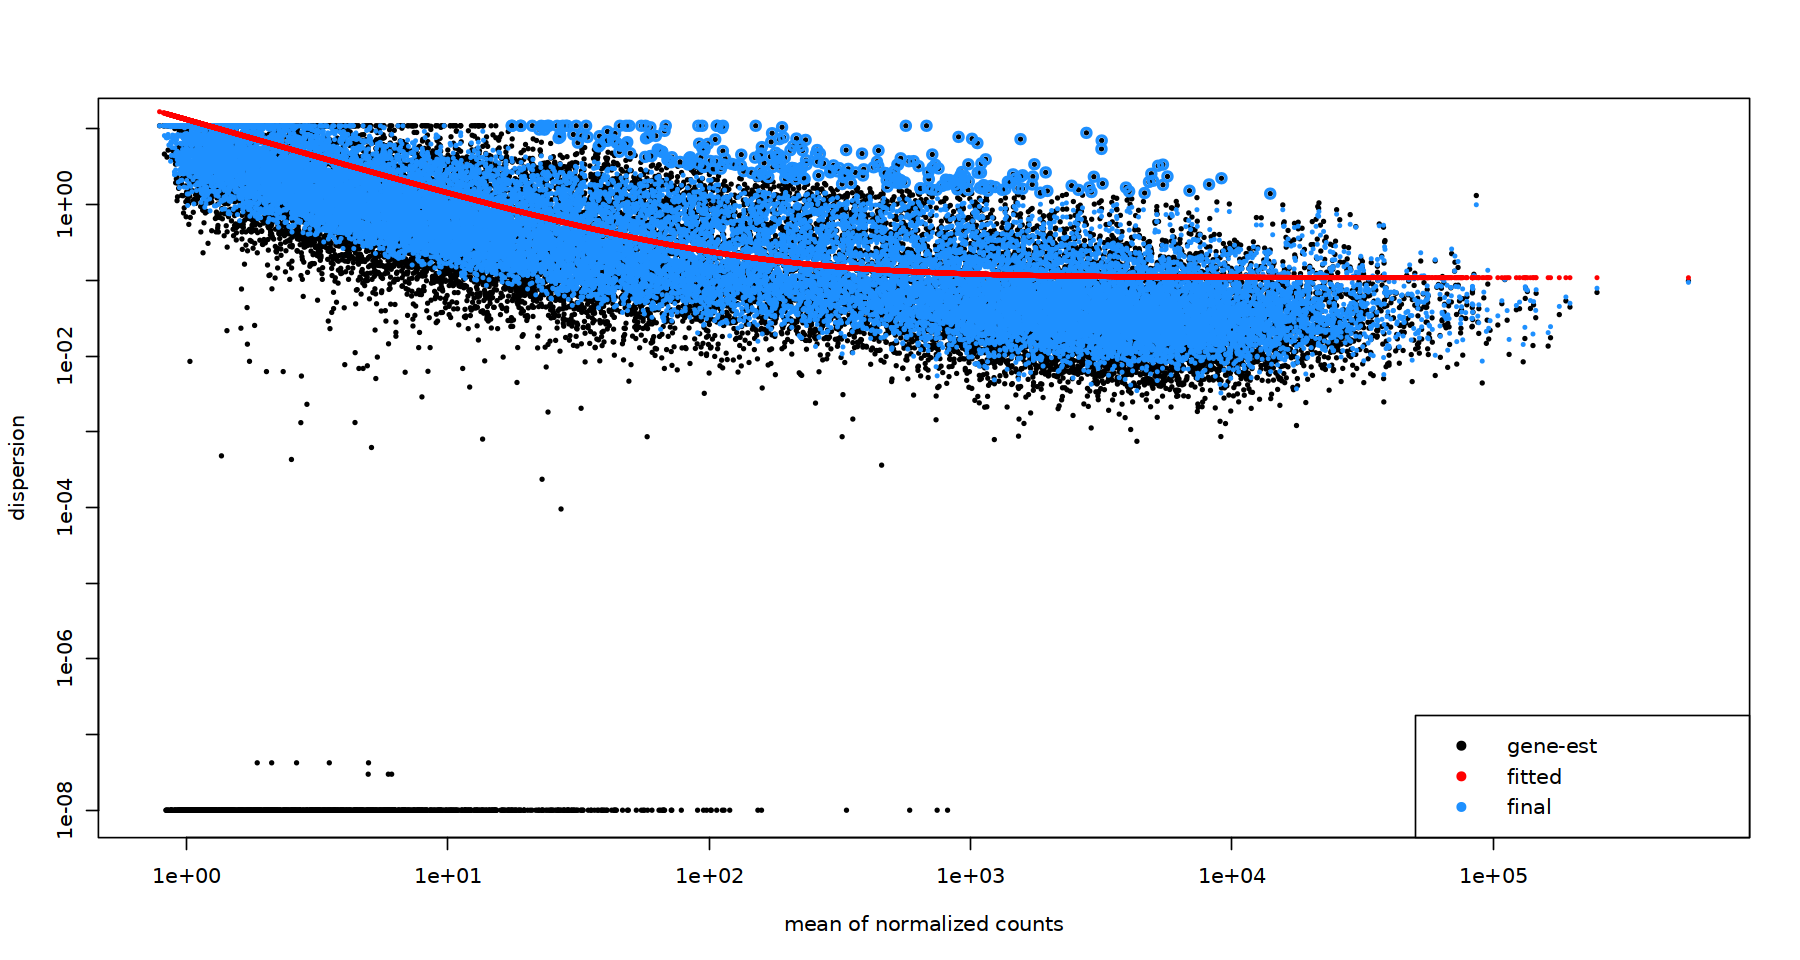

In [40]:
## Code cell 40 ##

plotDispEsts(dds2)

The plot here is as expected in a typical RNASeq data set where the dispersion increases when variance increases, but it decreases when mean increases.

Given the small sample size of most RNASeq datasets, estimation of gene variation is difficult. DESeq2 will borrow information from other genes to generate better estimates. It assumes that genes with similar expression levels have a similar variance. The red line corresponds to the fitted curve to gene-wise dispersion estimates. This curve facilitates the identification of DE genes when sample sizes are small. In blue is the estimated dispersion for each gene toward the predicted values by the curve.

- Now consider the **distribution of raw counts and normalized counts by DESeq()**:

In [41]:
## Code cell 41 ##

summary(counts(dds2)) # raw counts

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :     0      Min.   :     0      Min.   :     0     
 1st Qu.:     6      1st Qu.:     5      1st Qu.:     4     
 Median :    78      Median :    68      Median :    58     
 Mean   :  3458      Mean   :  2698      Mean   :  2458     
 3rd Qu.:  2401      3rd Qu.:  1986      3rd Qu.:  1752     
 Max.   :761411      Max.   :587831      Max.   :921265     
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :     0      Min.   :     0      Min.   :     0     
 1st Qu.:     5      1st Qu.:     3      1st Qu.:     4     
 Median :    65      Median :    53      Median :    60     
 Mean   :  2556      Mean   :  2844      Mean   :  2596     
 3rd Qu.:  1876      3rd Qu.:  2051      3rd Qu.:  2013     
 Max.   :930294      Max.   :509455      Max.   :425350     
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :     0.0          Min.   :     0            Min.   :     0

In [42]:
## Code cell 42 ##

summary(counts(dds2, normalize = TRUE))# normalized counts

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :     0.0    Min.   :     0.0    Min.   :      0.0  
 1st Qu.:     4.5    1st Qu.:     4.7    1st Qu.:      4.4  
 Median :    58.7    Median :    64.3    Median :     63.6  
 Mean   :  2602.1    Mean   :  2551.6    Mean   :   2693.5  
 3rd Qu.:  1806.7    3rd Qu.:  1878.5    3rd Qu.:   1920.0  
 Max.   :572958.6    Max.   :556019.5    Max.   :1009609.4  
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :     0.0    Min.   :     0.0    Min.   :     0.0   
 1st Qu.:     5.2    1st Qu.:     2.8    1st Qu.:     3.9   
 Median :    67.3    Median :    49.8    Median :    57.9   
 Mean   :  2647.7    Mean   :  2669.4    Mean   :  2503.1   
 3rd Qu.:  1943.0    3rd Qu.:  1925.4    3rd Qu.:  1941.5   
 Max.   :963515.8    Max.   :478262.4    Max.   :410197.4   
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :     0.0          Min.   :     0.0          Min.   :     0

We can plot these distribution of read counts (with a log2 transformation) using a boxplot, to verify that the read counts have indeed not yet been normalized between samples, unless we use `normalize = TRUE`.

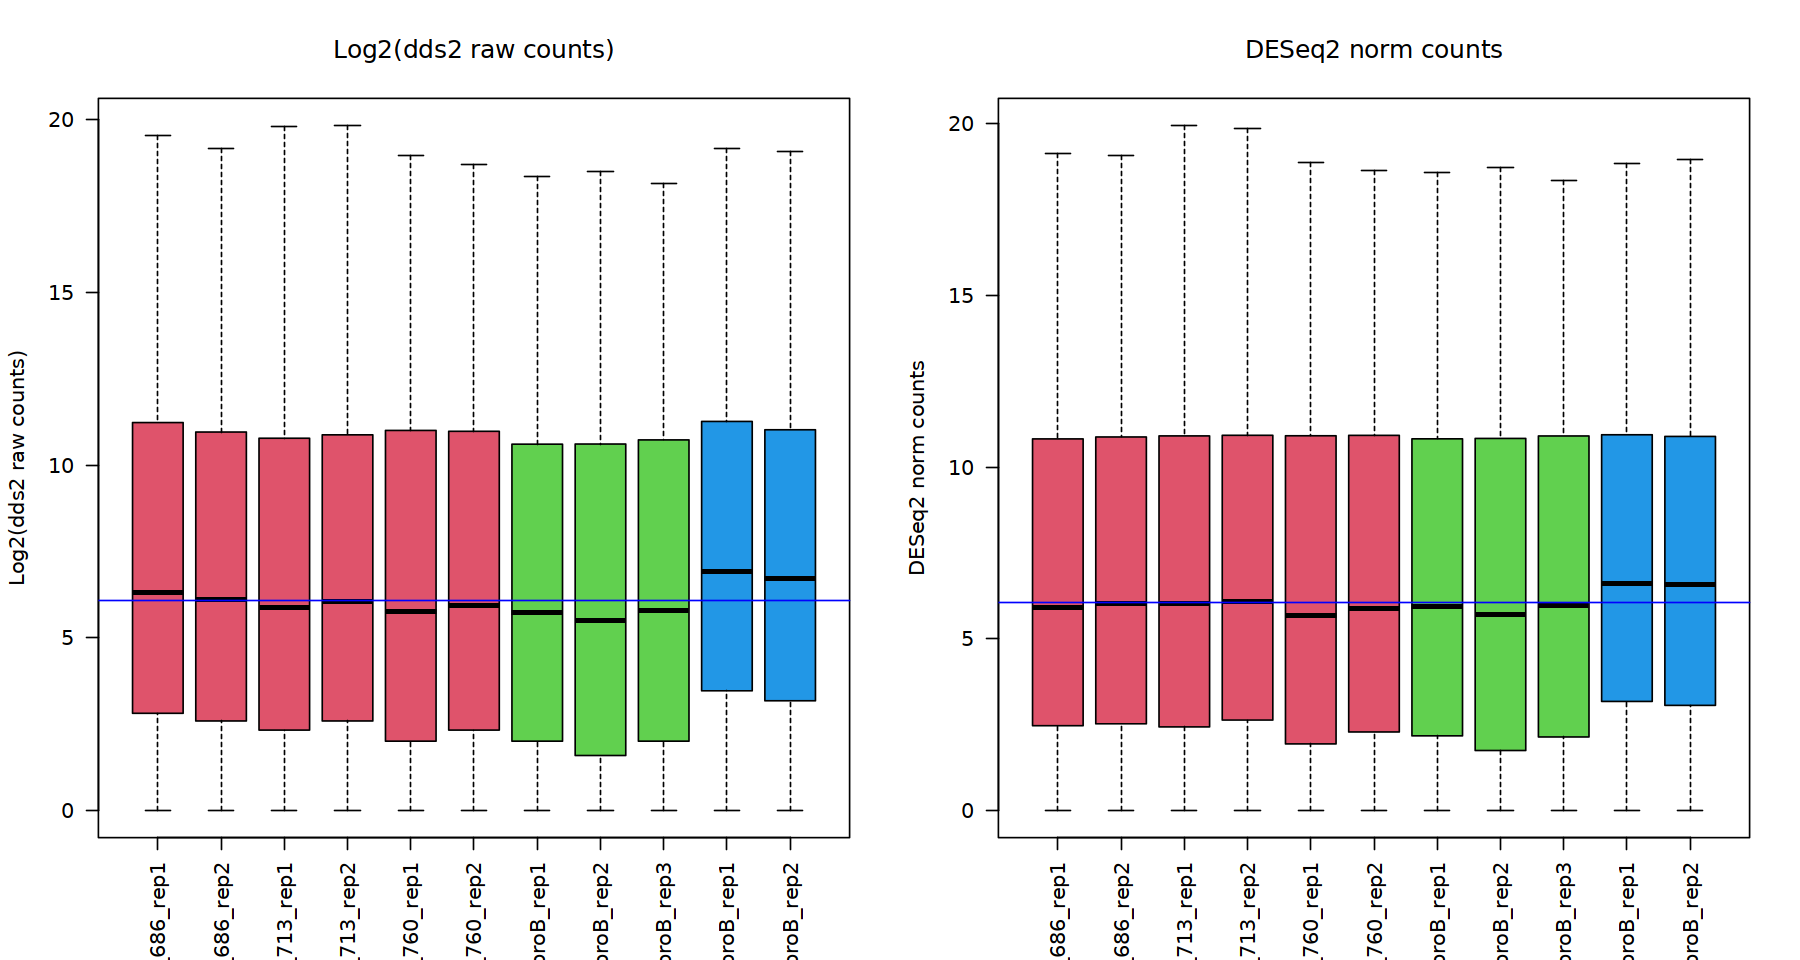

In [43]:
## Code cell 43 ##

# make a colour vector
#conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# to display the two plots side by side
layout(matrix(1:2, ncol=2))

# Check distributions of samples using boxplots for the non-normalised data in log2
boxplot(log2(counts(dds2)+1), outline = FALSE,
        xlab = "",
        ylab = "Log2(dds2 raw counts)",
        las = 2,
        col = conditionColor,
        main = "Log2(dds2 raw counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median.default(log2(counts(dds2)+1)), col = "blue")

# Check distributions of samples using boxplots
boxplot(log2(counts(dds2, normalize = TRUE)+1), outline = FALSE,
        xlab = "",
        ylab = "DESeq2 norm counts",
        las = 2,
        col = conditionColor,
        main = "DESeq2 norm counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median(log2(counts(dds2, normalize = TRUE) + 1)), col = "blue")


As we can see, the log2 transformation gives a data distribution closer to the normal distribution, but does not perform well for normalizing data between samples.    

The main motive behind normalization is to change numeric values in a dataset to a common scale without distorting the differences between samples. This reduces the sparsity of the data as they are brought to a common close scale.


<div class="alert alert-block alert-danger"> <b> Caution on DESeq() norm counts: </b><br><ul> <li>For further exploratory analyses, it is not recommanded to use the normalised counts from DESeq() but one of the 2 other normalisation methods: <code>rlog</code>and <code>vst</code>. We will test the effect of both in part 3.<il>
    <li> For DE analysis, DESeq() norm counts must not be used since the linear model was already tested with the function. We will see in part 4 how to perform the DE analysis with the factor and contrast of interest.<il> </div>

---
---
## 3 - Normalization of the data with `rlog` or `vst` for vizualisation and further exploratory analyses
---

The following two methods of normalization implemented in DESeq2 package are to be considered prior to exploratory analyses, like PCA, hierarchical clustering or heatmap, that will follow in the next pipeline.

### 3.1 - Data normalisation with `rlog`: Regularized-logarithm transformation
---

This function transforms the count data to the log2 scale in a way which minimizes differences between samples for rows with small counts, and which normalizes with respect to library size. For genes with high counts, rlog will not differ much from an ordinary log2 transformation.

> *In the function calls, we specified `blind = FALSE`, which means that differences between cell lines and treatment (the variables in the design) will not contribute to the expected variance-mean trend of the experiment. The experimental design is not used directly in the transformation, only in estimating the global amount of variability in the counts. For a fully **unsupervised** transformation, one can set `blind = TRUE` (which is the default).*   
[Love MI *et al.*, 2019](https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog)

`blind=FALSE` greatly reduces the run time.

In [44]:
## Code cell 44 ##

rlog.dds2 <- rlog(dds2, blind = FALSE)
rlog.dds2

class: DESeqTransform 
dim: 24432 11 
metadata(1): version
assays(1): ''
rownames(24432): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00002074899.1 ENSMUSG00000095041.8
rowData names(27): baseMean baseVar ... maxCooks rlogIntercept
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(11): SampleID SampleName ... Tissue sizeFactor

Let's verify the effect by plotting the counts from `rlog.dds2`, side by side with the non-normalised data to see the effect of normalisation.

In [45]:
## Code cell 45 ##

# Get log2 counts
counts.rlog.dds2 <- assay(rlog.dds2)

summary(counts.rlog.dds2) # summary for each column

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :-0.8128     Min.   :-0.8115     Min.   :-0.8105    
 1st Qu.: 2.2497     1st Qu.: 2.2565     1st Qu.: 2.2819    
 Median : 5.8141     Median : 5.8691     Median : 5.8700    
 Mean   : 6.4882     Mean   : 6.5112     Mean   : 6.5237    
 3rd Qu.:10.8095     3rd Qu.:10.8727     3rd Qu.:10.8949    
 Max.   :19.1125     Max.   :19.0747     Max.   :19.8296    
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :-0.8109     Min.   :-0.8115     Min.   :-0.8113    
 1st Qu.: 2.2970     1st Qu.: 2.1102     1st Qu.: 2.1776    
 Median : 5.9650     Median : 5.6234     Median : 5.7804    
 Mean   : 6.5454     Mean   : 6.4374     Mean   : 6.4771    
 3rd Qu.:10.9103     3rd Qu.:10.8983     3rd Qu.:10.9070    
 Max.   :19.7704     Max.   :18.8850     Max.   :18.6924    
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :-0.8091           Min.   :-0.8087           Min.   :-0.810

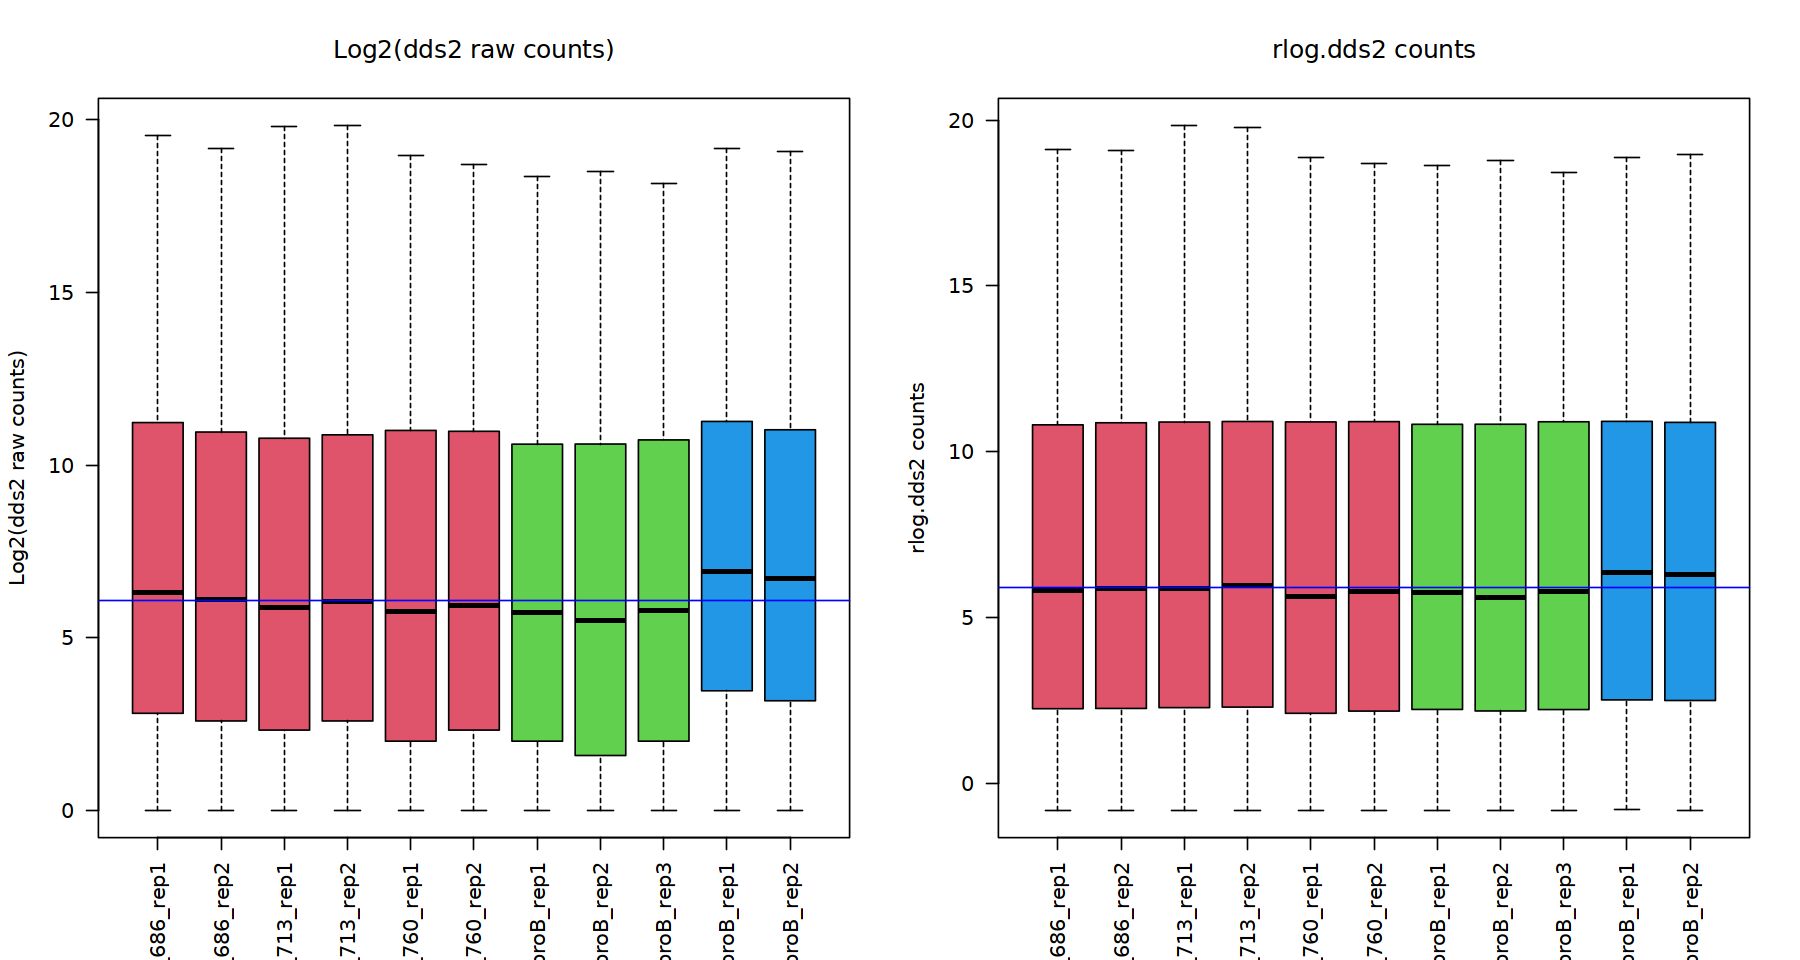

In [46]:
## Code cell 46 ##

# make a colour vector
#conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# to display the two plots side by side
layout(matrix(1:2, ncol=2))

# Check distributions of samples using boxplots for the non-normalised data in log2
boxplot(log2(counts(dds2)+1), outline = FALSE,
        xlab = "",
        ylab = "Log2(dds2 raw counts)",
        las = 2,
        col = conditionColor,
        main = "Log2(dds2 raw counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median.default(log2(counts(dds2)+1)), col = "blue")

# Check distributions of samples using boxplots for the rlog normalised data
boxplot(counts.rlog.dds2,
        xlab = "",
        ylab = "rlog.dds2 counts",
        las = 2,
        col = conditionColor,
        main = "rlog.dds2 counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median.default(counts.rlog.dds2), col = "blue")

We can also verify that the variance is not correlated any more to the average level of expression, by plotting standard deviation vs mean expression:

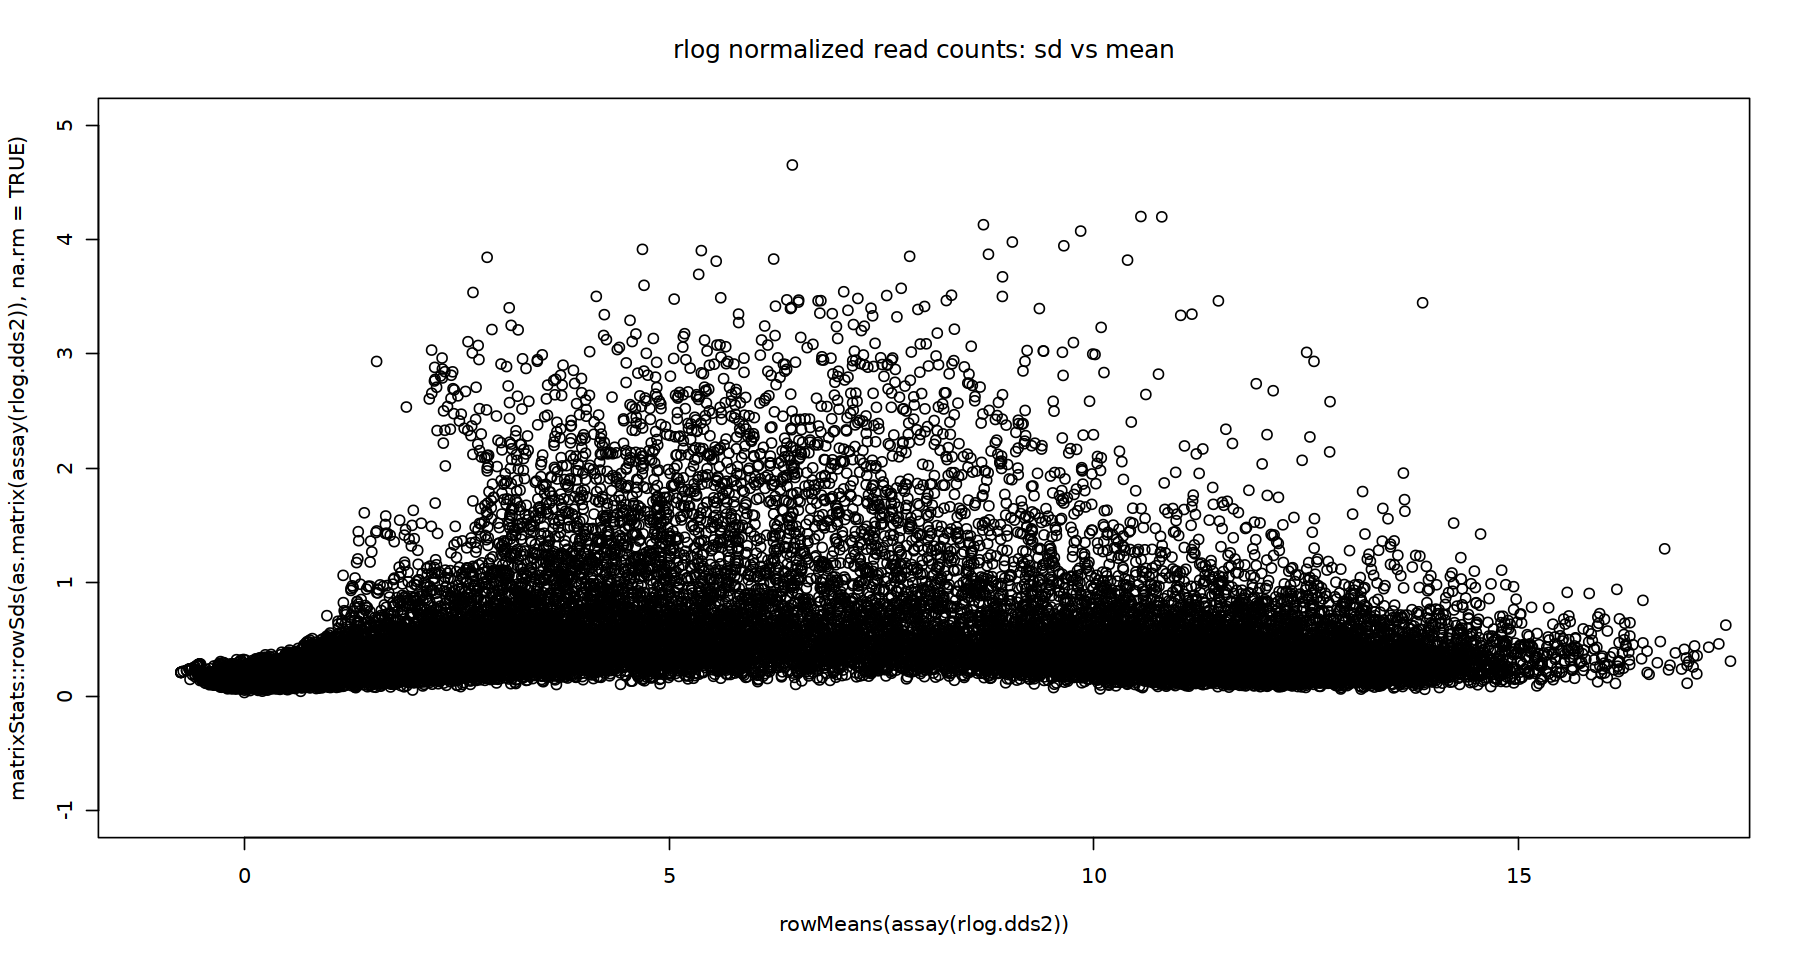

In [47]:
## Code cell 47 ##

# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(assay(rlog.dds2)), matrixStats::rowSds(as.matrix(assay(rlog.dds2)), na.rm = TRUE), 
     main = 'rlog normalized read counts: sd vs mean', 
     xlim = c(-1,17),
     ylim = c(-1,5))

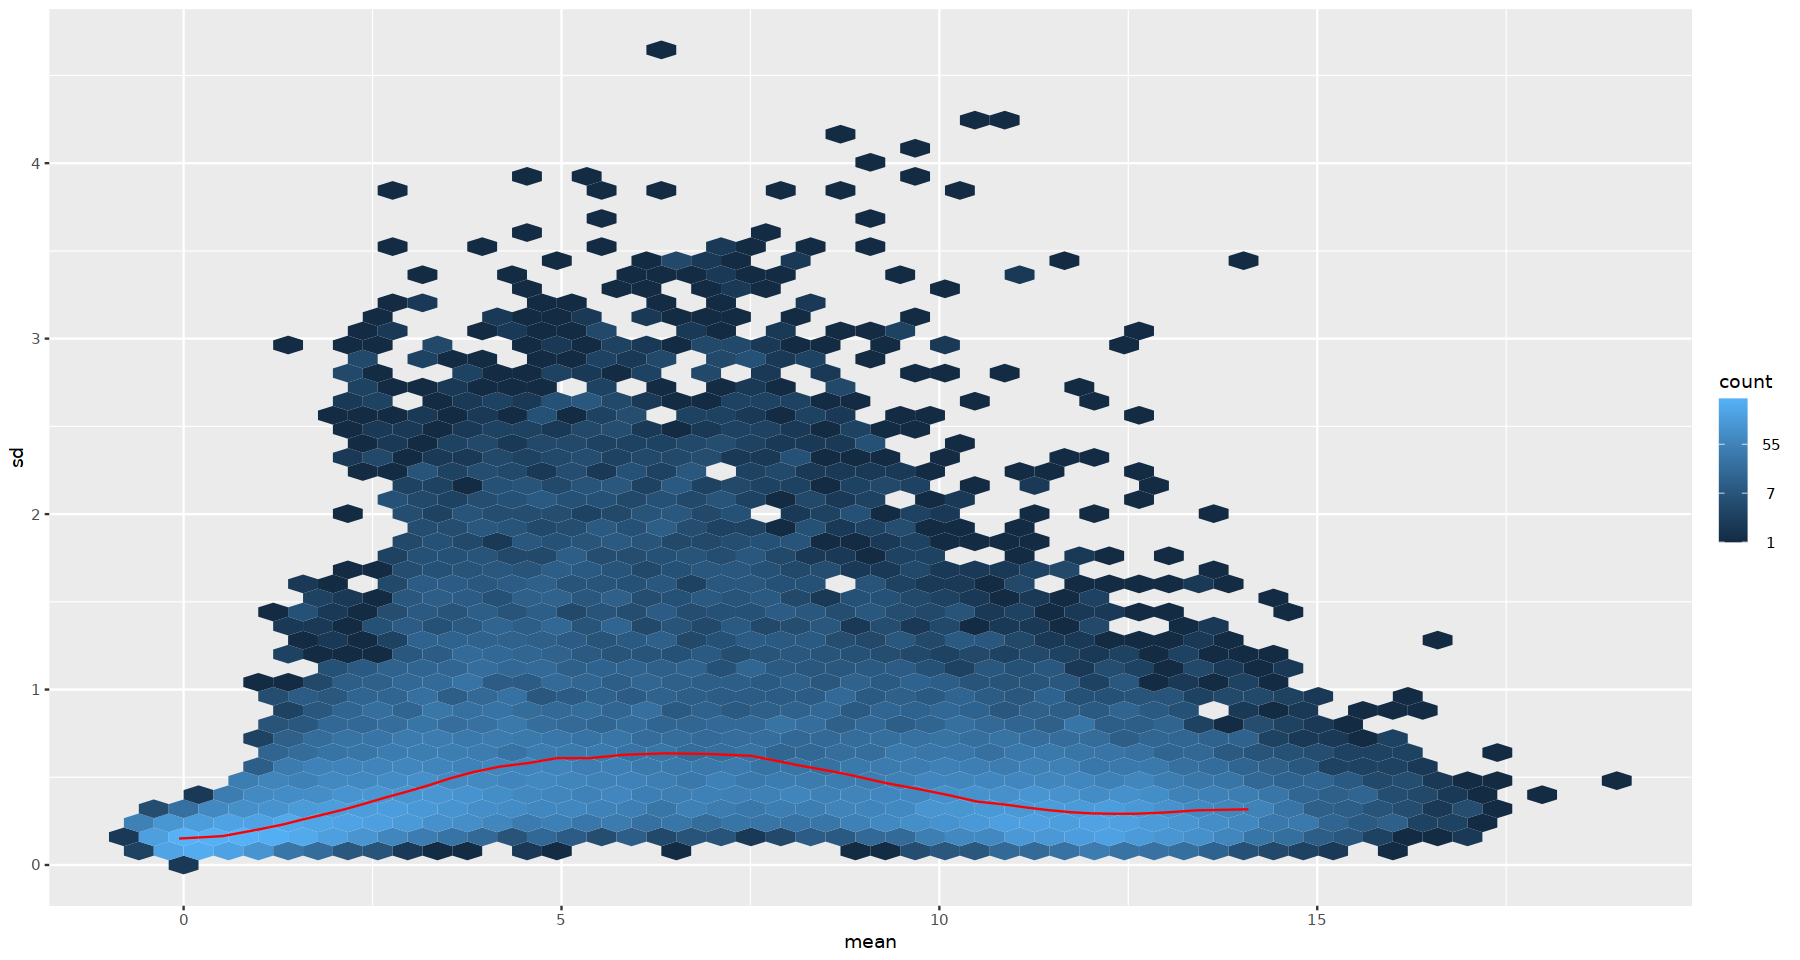

In [48]:
## Code cell 48 ##

vsn::meanSdPlot(assay(rlog.dds2), ranks = FALSE)

### 3.2 - Normalization with `vst`: variance stabilizing transformation
---

Variance stabilizing transformation (VST) aims at generating a matrix of values for which variance is constant across the range of mean values, especially for low means.

The vst function computes the fitted dispersion-mean relation, derives the transformation to apply and accounts for library size.

In [49]:
## Code cell 49 ##

vst.dds2 <- vst(dds2, blind = FALSE)
vst.dds2

class: DESeqTransform 
dim: 24432 11 
metadata(1): version
assays(1): ''
rownames(24432): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00002074899.1 ENSMUSG00000095041.8
rowData names(26): baseMean baseVar ... maxCooks dispFit
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(11): SampleID SampleName ... Tissue sizeFactor

Again, we check the effect by looking at summaries and plotting the log2 counts from `vst.dds2`

In [50]:
## Code cell 50 ##

# Get log2 counts
counts.vst.dds2 <- assay(vst.dds2)

summary(counts.vst.dds2) # summary for each column

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   : 5.637      Min.   : 5.637      Min.   : 5.637     
 1st Qu.: 6.070      1st Qu.: 6.080      1st Qu.: 6.064     
 Median : 7.136      Median : 7.200      Median : 7.191     
 Mean   : 8.476      Mean   : 8.490      Mean   : 8.499     
 3rd Qu.:10.896      3rd Qu.:10.949      3rd Qu.:10.979     
 Max.   :19.128      Max.   :19.085      Max.   :19.946     
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   : 5.637      Min.   : 5.637      Min.   : 5.637     
 1st Qu.: 6.100      1st Qu.: 5.979      1st Qu.: 6.037     
 Median : 7.232      Median : 7.025      Median : 7.126     
 Mean   : 8.519      Mean   : 8.452      Mean   : 8.476     
 3rd Qu.:10.995      3rd Qu.:10.983      3rd Qu.:10.994     
 Max.   :19.878      Max.   :18.868      Max.   :18.646     
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   : 5.637            Min.   : 5.637            Min.   : 5.637

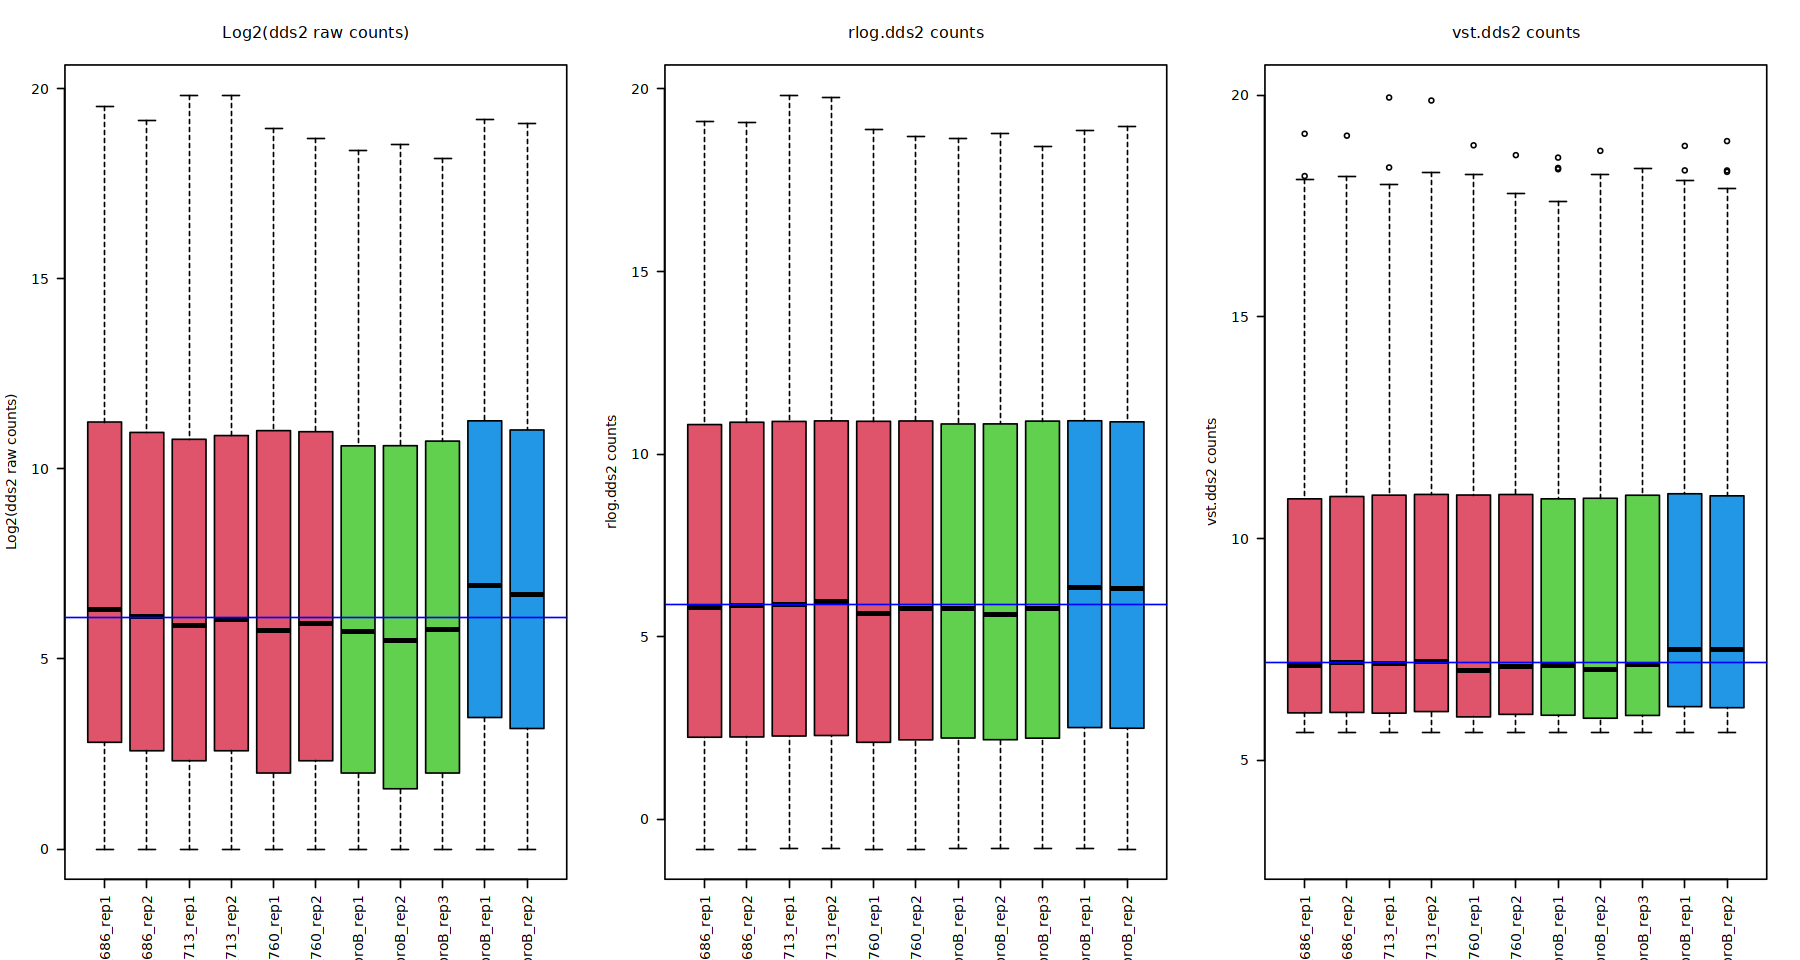

In [51]:
## Code cell 51 ##

# make a colour vector
#conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# to display the two plots side by side
layout(matrix(1:3, ncol = 3))


# Check distributions of samples using boxplots for the non-normalised data in log2
boxplot(log2(counts(dds2)+1), outline = FALSE,
        xlab = "",
        ylab = "Log2(dds2 raw counts)",
        las = 2,
        col = conditionColor,
        main = "Log2(dds2 raw counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median.default(log2(counts(dds2) + 1)), col = "blue")

# Check distributions of samples using boxplots for the rlog normalised data
boxplot(counts.rlog.dds2,
        xlab = "",
        ylab = "rlog.dds2 counts",
        las = 2,
        col = conditionColor,
        main = "rlog.dds2 counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median.default(counts.rlog.dds2), col = "blue")

# Check distributions of samples using boxplots
boxplot(counts.vst.dds2,
        xlab = "",
        ylab = "vst.dds2 counts",
        las = 2,
        ylim=c(3,20),
        col = conditionColor,
        main = "vst.dds2 counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median.default(counts.vst.dds2), col = "blue")

We also verify the decoupling of variance and mean level of expression:

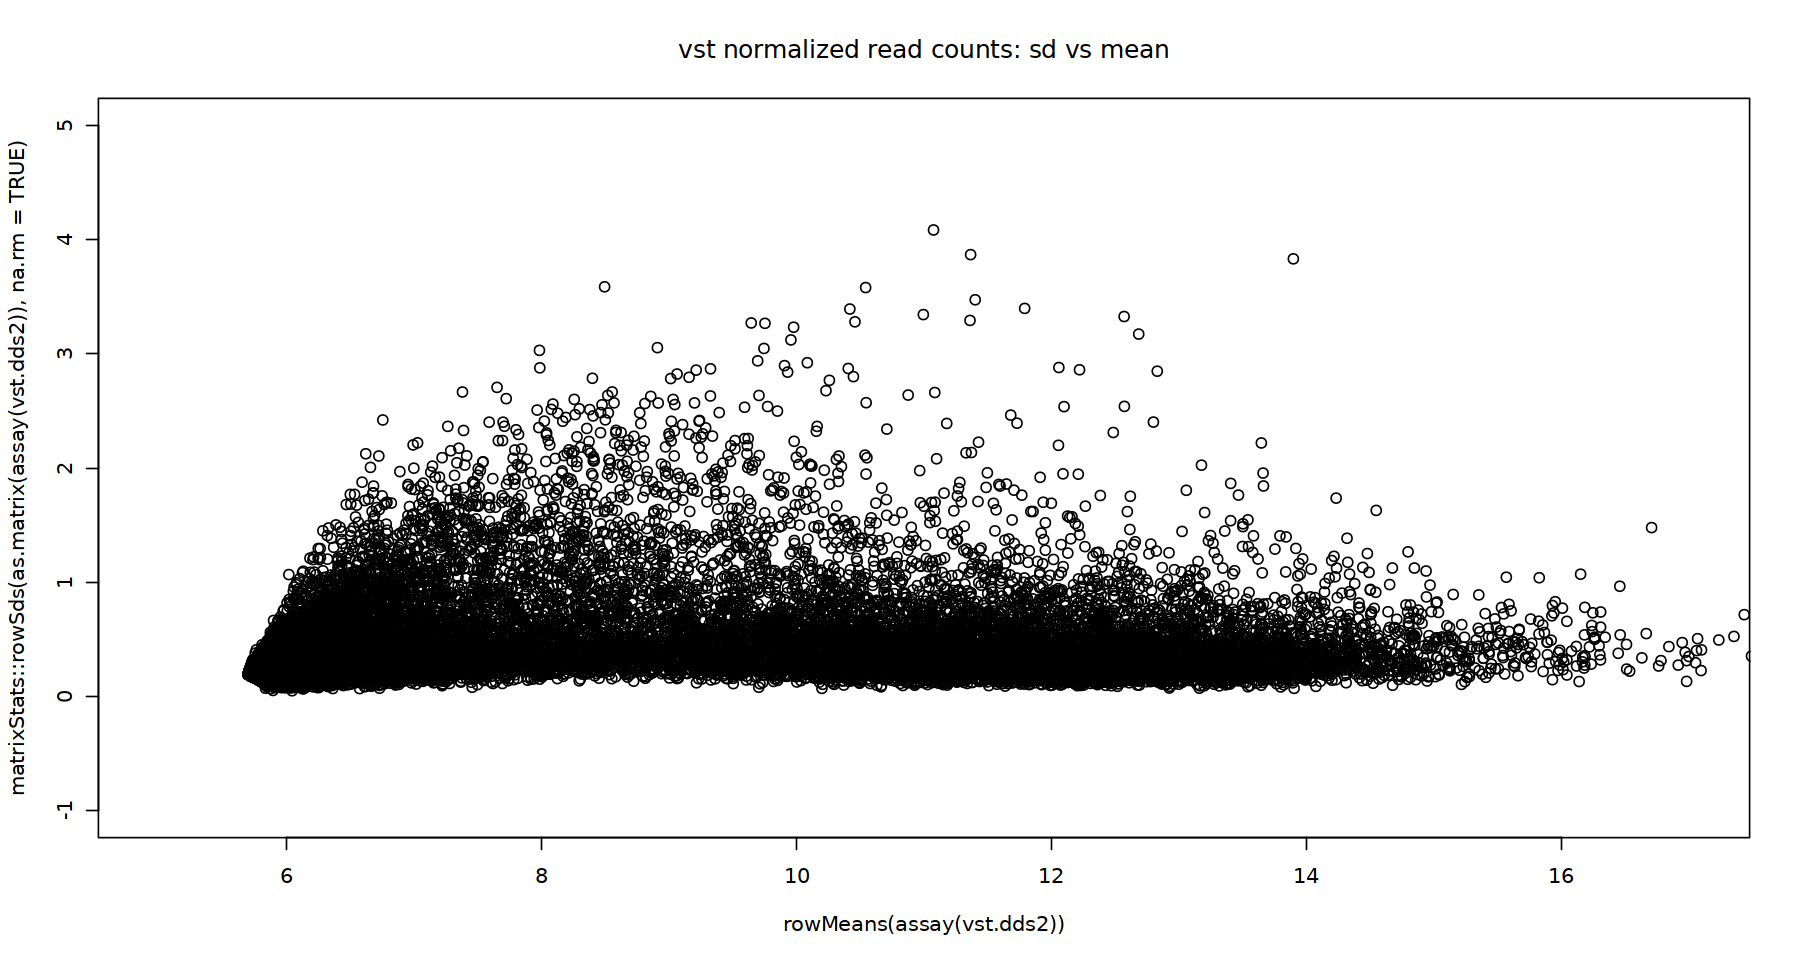

In [52]:
## Code cell 52 ##

# Raw counts mean expression Vs Standard Deviation (SD)
plot(rowMeans(assay(vst.dds2)), matrixStats::rowSds(as.matrix(assay(vst.dds2)), na.rm = TRUE), 
     main = 'vst normalized read counts: sd vs mean', 
     xlim = c(5,17),
     ylim = c(-1,5))

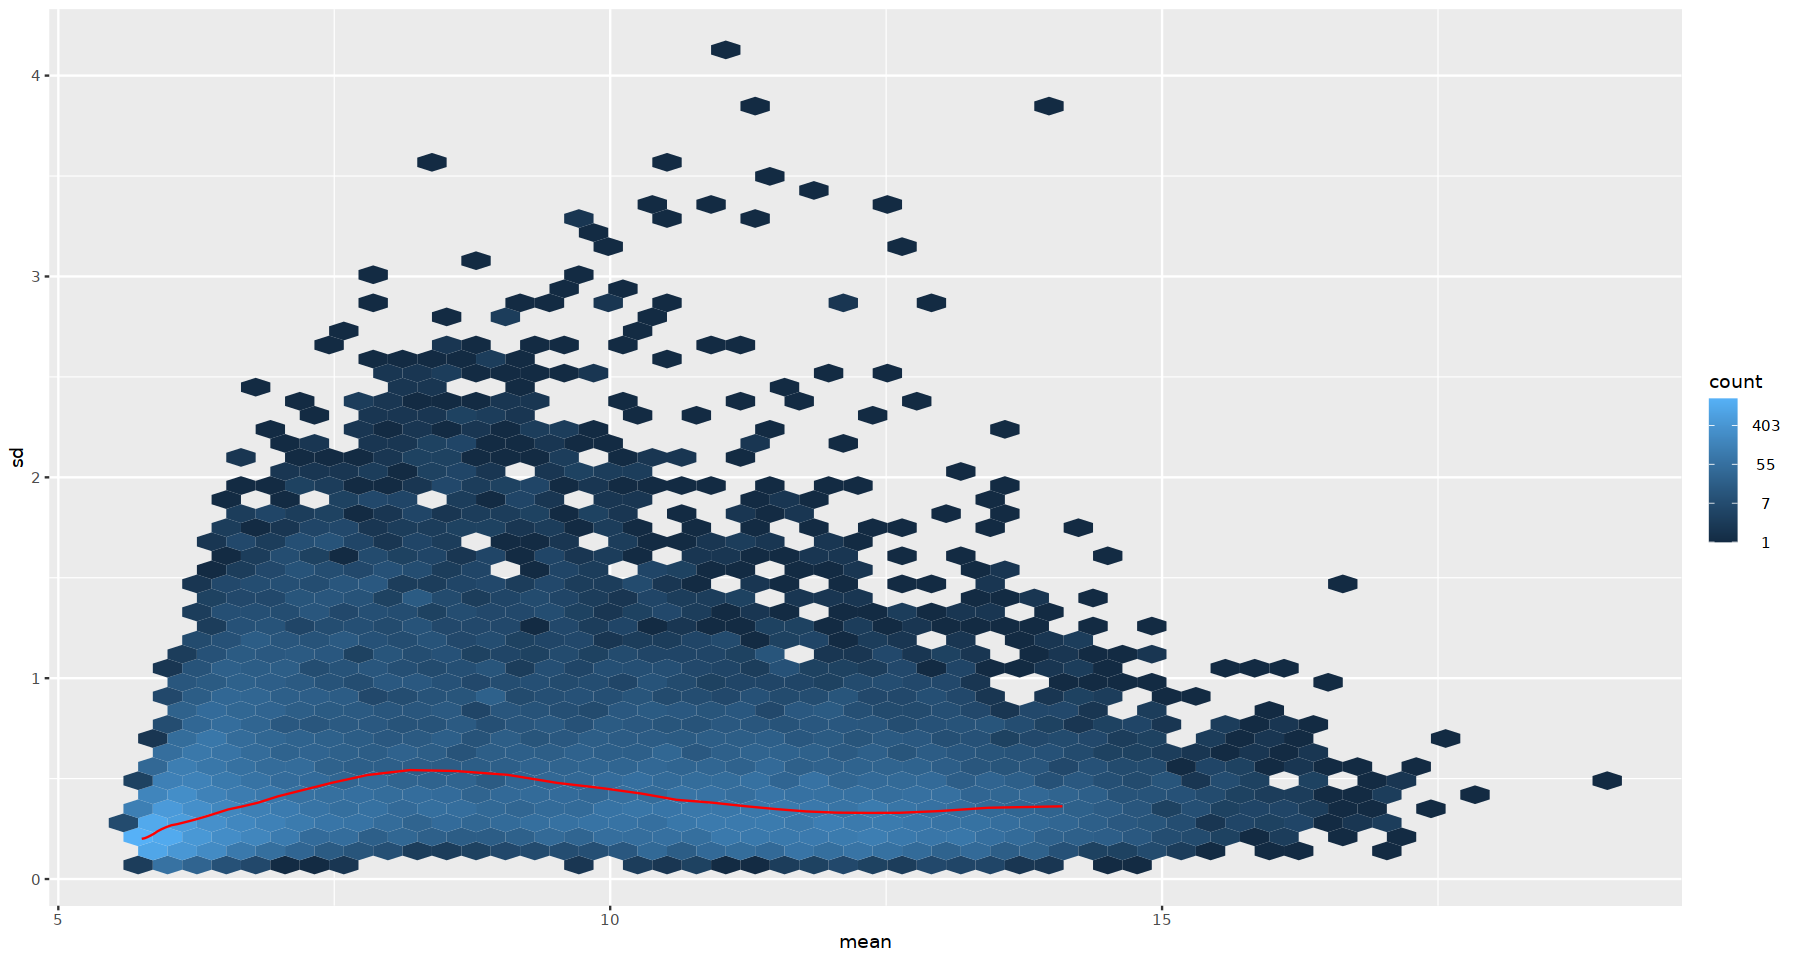

In [53]:
## Code cell 53 ##

vsn::meanSdPlot(assay(vst.dds2), ranks = FALSE)


We can also display the scatterplot of transformed counts from two samples:

Warning message:
"`as_data_frame()` was deprecated in tibble 2.0.0.
i Please use `as_tibble()` (with slightly different semantics) to convert to a
  tibble, or `as.data.frame()` to convert to a data frame."


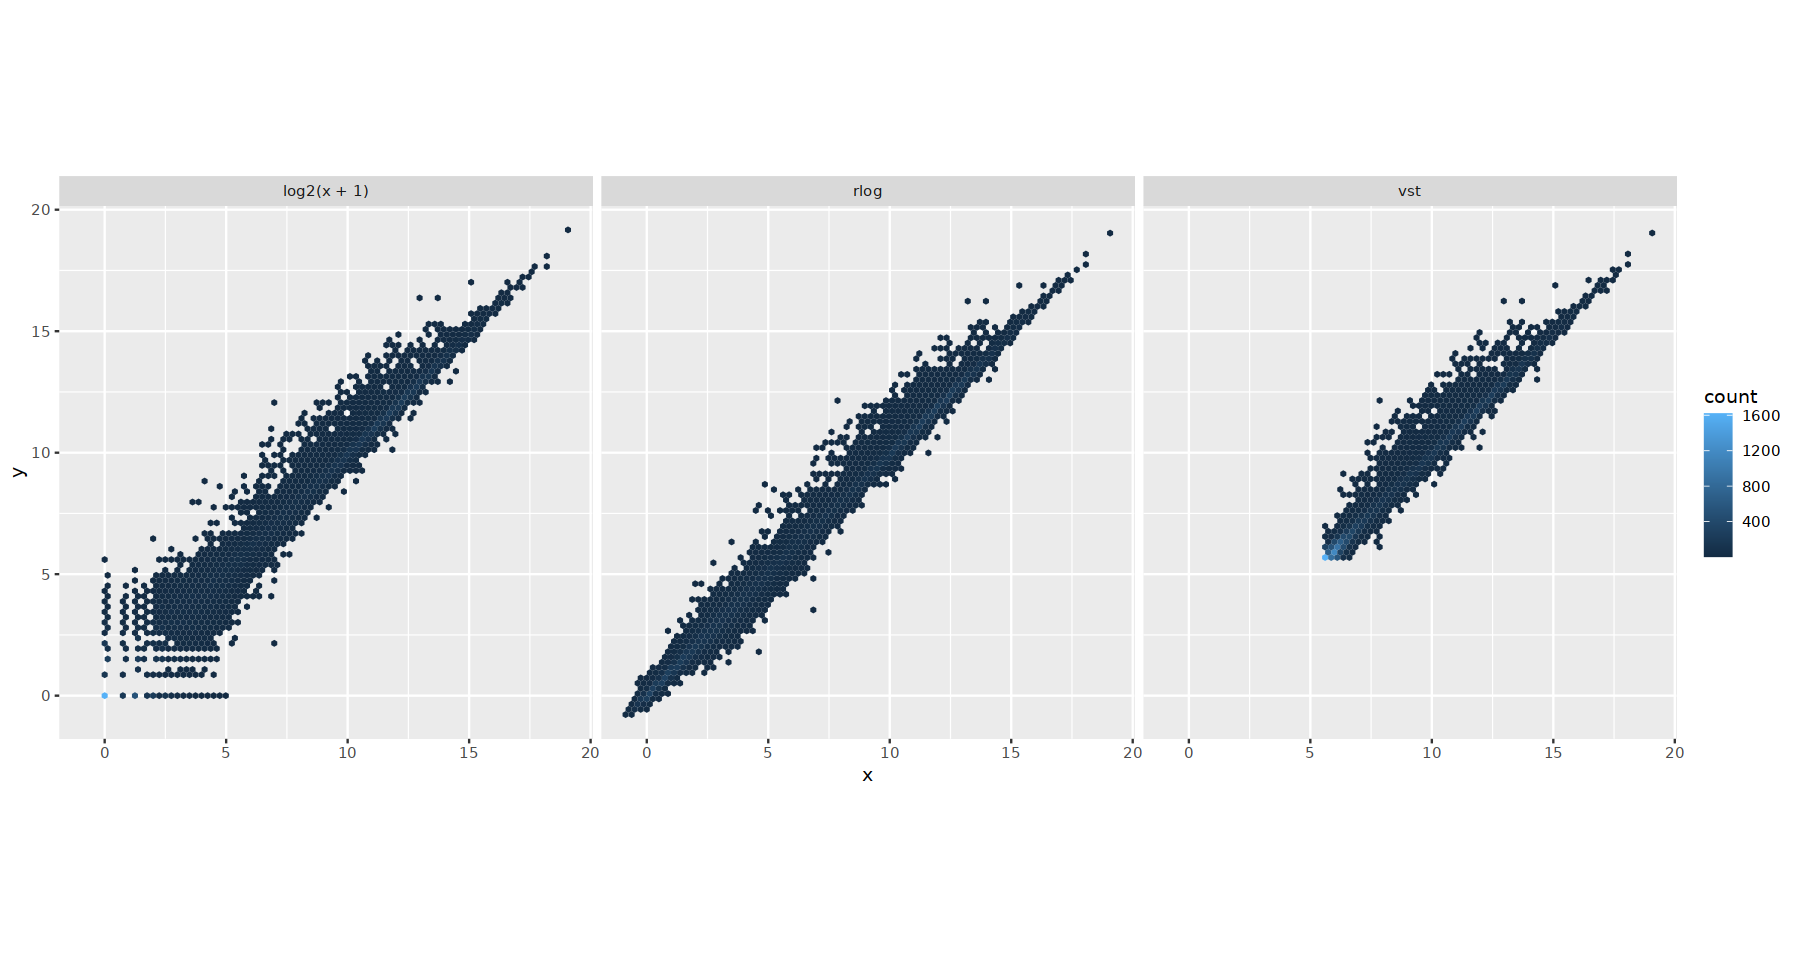

In [54]:
## Code cell 54 ##

df <- bind_rows(
  as_data_frame(log2(counts(dds2, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(rlog.dds2)[, 1:2]) %>% mutate(transformation = "rlog"),
  as_data_frame(assay(vst.dds2)[, 1:2]) %>% mutate(transformation = "vst"))
  
colnames(df)[1:2] <- c("x", "y")  

lvls <- c("log2(x + 1)", "rlog", "vst")
df$transformation <- factor(df$transformation, levels=lvls)

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

### 3.3- Choosing the best transformation for our data for further exploratory analyses
---

You can see that both methods worked on our data, even if the outputs are different.   
    
The indications to guide the choice between the two methods are:

> *For genes with high counts, both the VST and the rlog will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards a middle value. The VST or rlog-transformed data then become approximately homoskedastic (more flat trend in the meanSdPlot), and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data.  
> **Which transformation to choose?** The VST is much faster to compute and is less sensitive to high count outliers than the rlog. The rlog tends to work well on small datasets (n < 30), potentially outperforming the VST when there is a wide range of sequencing depth across samples (an order of magnitude difference). We therefore recommend the VST for medium-to-large datasets (n > 30). You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.*  
[Love MI *et al.*, 2019](https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog)

In addition to the notions above, VST transformation can be useful even for small datasets, in the cases when one variable presents a much larger variance than the other variables. Then, the scaling effect provided by VST is more powerful than with rlog. 

Both tranformation methods performed well on our dataset, but we can notice that, in the rlog normalisation, the distribution appear more centered on the median for each sample, and the variance seems less related to the mean level of expression, especially for low values. Furthermore, there are still some outliers for the vst nomalisation.  

Thus, we will keep the **rlog** transformation to go on with the the second exploratory analysis in the next notebook.

In [55]:
## Code cell 55 ##

head(assay(rlog.dds2))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,2.79304049,1.81549622,6.29070228,6.09468679,6.8864018,7.2603992,1.93132119,1.93466381,1.91549040,1.72255191,2.30844035
ENSMUSG00000104238.2,-0.09021838,-0.08772794,-0.08588542,-0.08661565,0.1831222,0.7787548,-0.08507899,-0.08499663,-0.08546441,-0.08958484,-0.08811938
ENSMUSG00000102269.2,1.58287052,1.78910047,1.65122950,1.41704819,1.6209785,1.8875758,1.73223396,1.58998943,1.50497826,1.59297925,1.67453739
ENSMUSG00000098104.2,7.49185409,7.56594425,7.92605006,7.74132379,7.7445271,7.5521564,8.17829270,7.28098828,7.76238661,7.91715956,7.86305936
ENSMUSG00000102175.2,1.03730098,1.32367604,1.21626302,1.51718869,1.0402541,1.3282378,1.04368392,1.04378812,1.36784518,1.38720409,1.18951441
ENSMUSG00000103922.2,6.33118241,6.55309964,6.52521864,6.27418798,6.7202852,6.0214489,6.03723997,5.71305280,5.98925608,6.36704382,6.33498377


Before saving the rlog counts for further analysis, we will merge this data with the gene info stored in gencode dataframe in order to have gene names in addition to Ensembl IDs. 

In the `merge()` function, we specify both dataframes, followed by `by.x = 0` to indicate the `gene_id` key is present in the row names of the first dataframe.

In [56]:
## Code cell 56 ##

rlog.dds2.annot <- merge(as.data.frame(assay(rlog.dds2)),
                gencode,
                by.x = 0, by.y = "gene_id",
                all.x = T, sort = F)
names(rlog.dds2.annot)[1] <- "ensemblID"

In [57]:
## Code cell 57 ##

head(rlog.dds2.annot)

,ensemblID,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,...,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000025902.14,2.79304049,1.81549622,6.29070228,6.09468679,6.8864018,7.2603992,1.93132119,1.93466381,1.91549040,...,chr1,HAVANA,4561154,4567577,-,protein_coding,Sox17,level 2,MGI:107543,OTTMUSG00000050014.7
2,ENSMUSG00000104238.2,-0.09021838,-0.08772794,-0.08588542,-0.08661565,0.1831222,0.7787548,-0.08507899,-0.08499663,-0.08546441,...,chr1,HAVANA,4566774,4569781,+,lncRNA,Gm37587,level 2,MGI:5610815,OTTMUSG00000050024.2
3,ENSMUSG00000102269.2,1.58287052,1.78910047,1.65122950,1.41704819,1.6209785,1.8875758,1.73223396,1.58998943,1.50497826,...,chr1,HAVANA,4593128,4596960,+,processed_pseudogene,Gm7357,level 2,MGI:3643257,OTTMUSG00000050025.1
4,ENSMUSG00000098104.2,7.49185409,7.56594425,7.92605006,7.74132379,7.7445271,7.5521564,8.17829270,7.28098828,7.76238661,...,chr1,HAVANA,4758157,4759626,-,processed_pseudogene,Gm6085,level 2,MGI:3646770,OTTMUSG00000043092.1
5,ENSMUSG00000102175.2,1.03730098,1.32367604,1.21626302,1.51718869,1.0402541,1.3282378,1.04368392,1.04378812,1.36784518,...,chr1,HAVANA,4762442,4763647,-,processed_pseudogene,Gm6119,level 2,MGI:3644547,OTTMUSG00000050009.1
6,ENSMUSG00000103922.2,6.33118241,6.55309964,6.52521864,6.27418798,6.7202852,6.0214489,6.03723997,5.71305280,5.98925608,...,chr1,HAVANA,4841354,4842422,+,processed_pseudogene,Gm6123,level 2,MGI:3647047,OTTMUSG00000050042.1


---
---
## 4 - Differential expression analysis with `DESeq2`
---

Differential expression analysis is classically the main way to analyse expression data from a quantitative point of view.   
This approach relies on statistical tests to identify the genes that present a level of expression that is significantly different  from one condition to another, or between several conditions.  
The genes are therefore considered as Differentially Expressed, and you'll often see the abreviation *DE genes*.   

To identify those DE genes, we need to:
- define the comparison(s) that we want to perform, by building a *contrast*
- run the analysis of expression data using this constrast. 

Tools such as `DESeq2` will :
- take into account the contrast to define the groups to compare, 
- compute the within-group and the between-group variability, 
- run a statistical test on each gene to look for statistically-significant differences of expression, 
- correct the resulting p-value to account for multiple testing
- return the list of genes with an adjusted p-value below a given threshold

### 4.1 - Building the results table
---

The `results` table is a dataframe that contains the differentially expressed genes, their raw and corrected p-values, whether the genes are upregulated or downregulated, the number of outliers, etc.  

`summary()` gives us the genes that are up and down regulated in our condition under study, as well as low count genes and outliers. This generates summary tarries for the data. You can read about more about the results function by looking up `?results`

* **Choose the comparison to perform**

We begin by defining the contrast, that is the comparison that we want to perform.  
When generating dds2, we specified the WT group as a reference. We can see that the current model design will test the contrats between either dHet or dHetRag versus the WT group.

In [58]:
## Code cell 58 ##

resultsNames(dds2)

[1] "Intercept"               "Condition_dHet_vs_WT"   
[3] "Condition_dHetRag_vs_WT"

We can always define new contrasts.

  
Here we choose to compare **the ALL leukemic cells to the dHet-Rag non leukemic ones**: 

In [59]:
## Code cell 59 ##

dHet_dHetRag <- c("Condition", "dHet", "dHetRag")

* **Perform the comparison between groups**

Now we can run `DESeq2` for this comparison. It will not work on the normalised rlog.dds2, but on the not-yet normalised dds2 : indeed the normalisation step has to take into account the inter-group variability and the intra-group variability to be correct, meaning that... the groups have to be defined first!   
Now that `DESeq2` knows which groups we want to compare, thanks to the `contrast` defined above, it will run the normalisation on the fly, and identify the genes that are significantly differentially expressed (DE genes) according to that specific normalisation.  

In [60]:
## Code cell 60 ##

res_dHet_dHetRag <- results(dds2, contrast = dHet_dHetRag)
summary(res_dHet_dHetRag)


out of 24432 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4954, 20%
LFC < 0 (down)     : 3802, 16%
outliers [1]       : 48, 0.2%
low counts [2]     : 2369, 9.7%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Here, we found very few outliers, and we have 9.7 % of low counts genes.   
The threshold used to consider a gene as significantly differentially expressed is an adjusted p-value of 0.1. Adjusted p-value means that a correction has been performed on the raw p-value, to take into consideration that the statistical test have been reiterated many times, as many as the number of genes. On such a high number of tests, numerous tests will give a "significant result" only by chance.   
The most-commonly used p-value correction in trascriptomic studies is the **Benjamini-Hochberg method**, it is the one used by default by `DESeq2`. You could specify another one in the argument of the function.  

We obtain 4954 significantly up-regulated genes + 3802 significantly down-regulated genes. LFC stands for Log2 Fold Change, that is the ratio of the expression of a given gene in the test conditon on its expression in the Reference condition, in log2 scale. Therefore, a log2 FC of 1 means that the gene is 2-times more expressed in the test samples versus the reference samples.

*For information, if we run the comparison between `dHet`and `WT` cells, we obtain:*    

out of 24432 with nonzero total read count   
adjusted p-value < 0.1   
LFC > 0 (up)       : 3590, 15%   
LFC < 0 (down)     : 3409, 14%   
outliers [1]       : 48, 0.2%   
low counts [2]     : 2842, 12%   
(mean count < 2)   
[1] see 'cooksCutoff' argument of ?results   
[2] see 'independentFiltering' argument of ?results   



**Plotting the distribution of adjusted p-values (after correction)**

Just to have an idea of the distribution of p-values after the DE test, we retrieve the total result of our test by `DESeq2`. The trick is to set `alpha` to (almost) 1.


In [61]:
## Code cell 69 ##

resTot_dHet_dHetRag <- results(dds2, contrast = dHet_dHetRag,  alpha = 0.99999999999999)
summary(resTot_dHet_dHetRag)


out of 24432 with nonzero total read count
adjusted p-value < 0.99999999999999
LFC > 0 (up)       : 12590, 52%
LFC < 0 (down)     : 11424, 47%
outliers [1]       : 48, 0.2%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



and we plot the resulting histogram: 

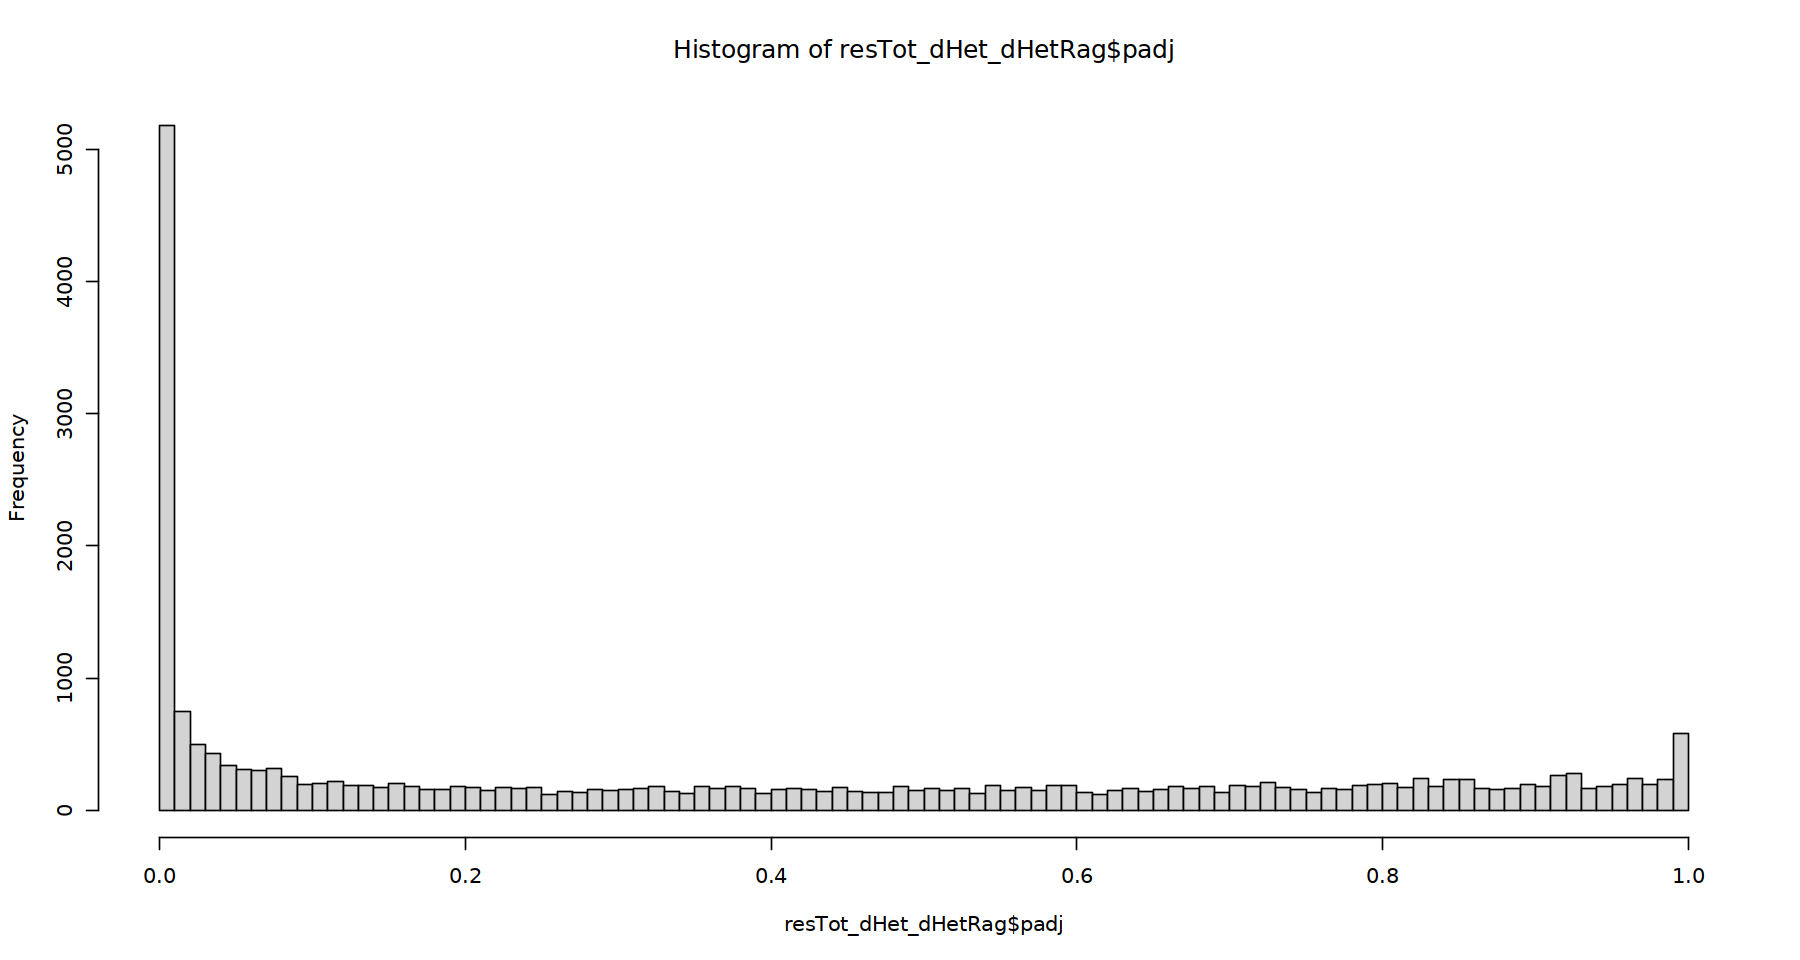

In [62]:
## Code cell 70 ##

hist(resTot_dHet_dHetRag$padj, xlim = c(0,1),breaks = 100)

We can zoom on the lowest p-values and see the effect of the multiple test correction:

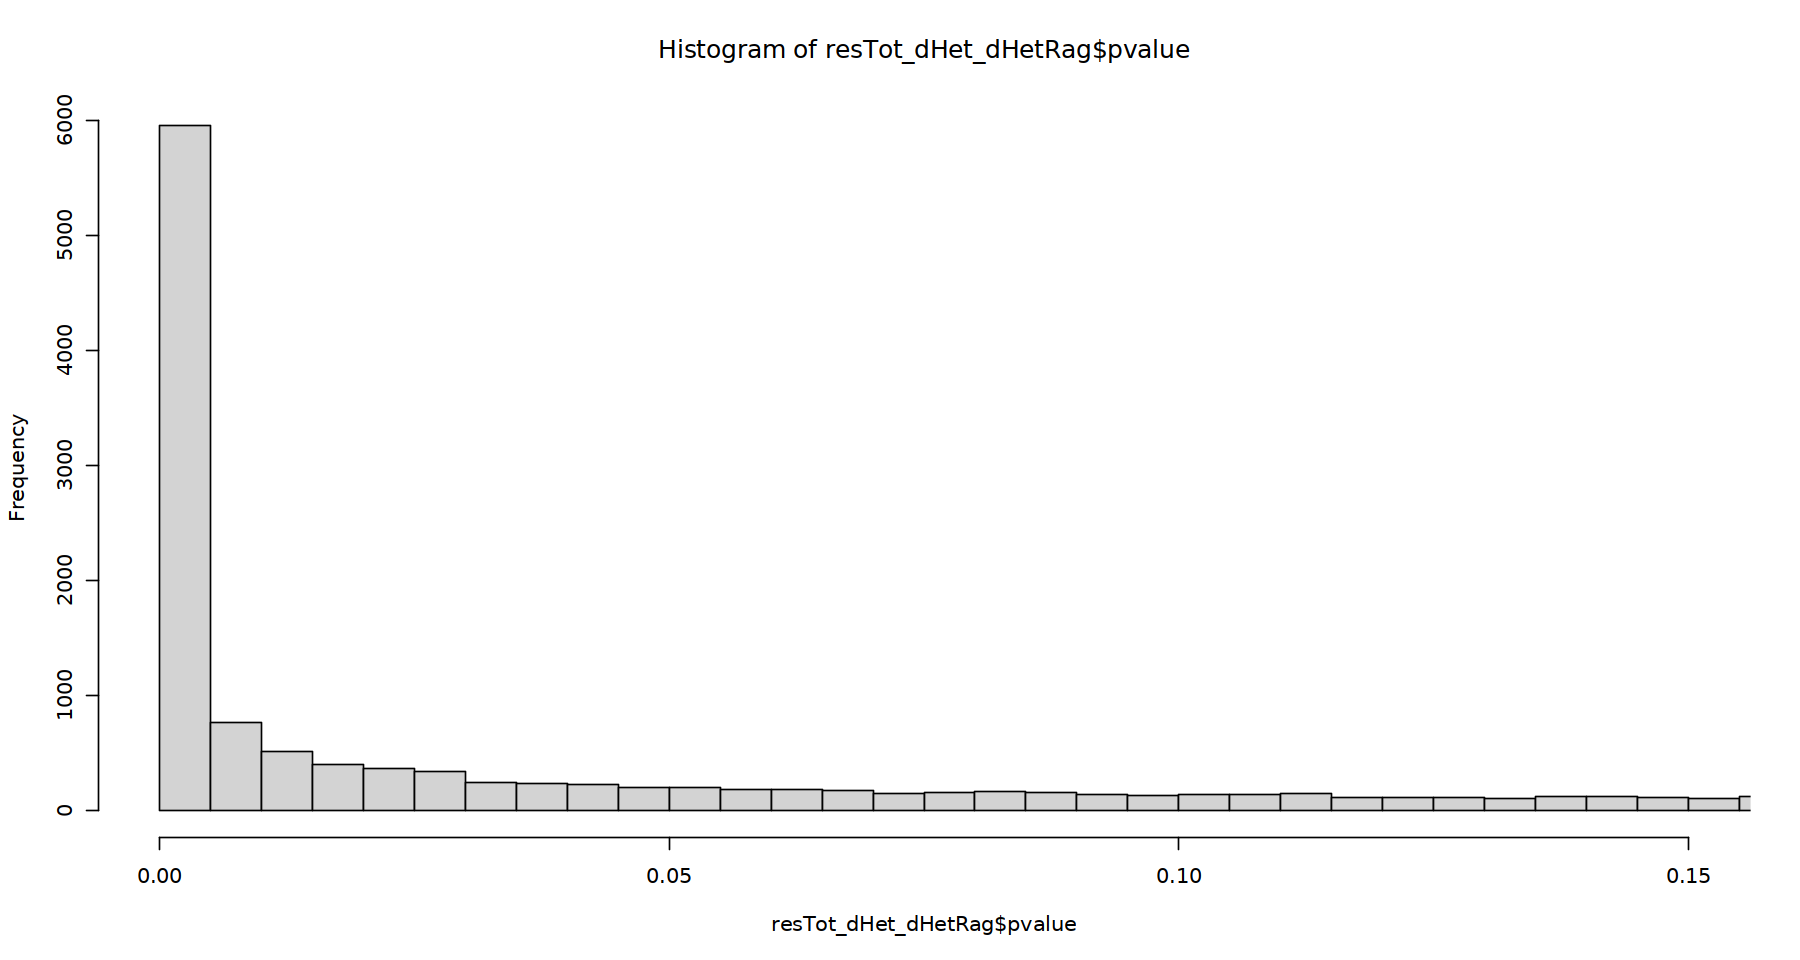

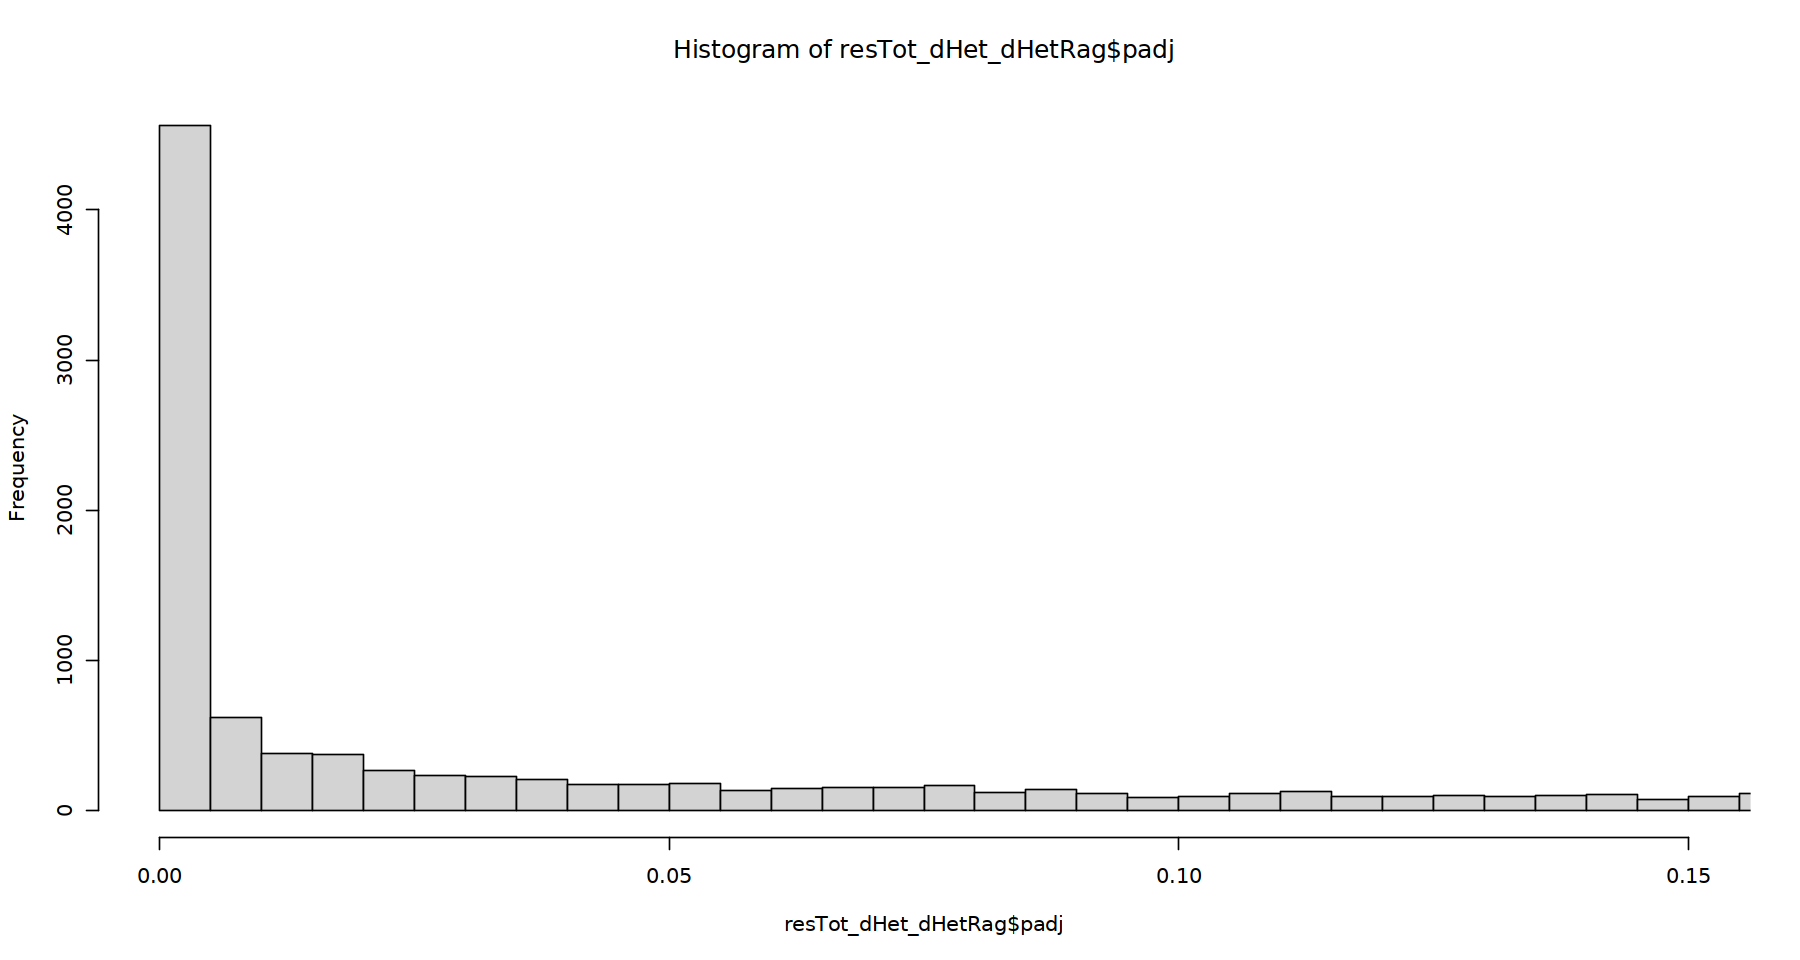

In [63]:
## Code cell 72 ##
hist(resTot_dHet_dHetRag$pvalue, xlim = c(0,0.15),breaks = 200)
hist(resTot_dHet_dHetRag$padj, xlim = c(0,0.15),breaks = 200)

### 4.2 - Working with a different threshold: alpha 0.05

By default, the result function uses an adjusted p-value (FDR) cutoff of 0.1. If any other p-value threshold is prefered, `alpha` should be set to that value, as shown below where we set `alpha=0.05`.

In [64]:
## Code cell 61 ##

res2_dHet_dHetRag <- results(dds2, contrast = dHet_dHetRag,  alpha = 0.05)
summary(res2_dHet_dHetRag)


out of 24432 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4255, 17%
LFC < 0 (down)     : 3119, 13%
outliers [1]       : 48, 0.2%
low counts [2]     : 2369, 9.7%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



We can now count the number of differentially expressed genes with adjusted p-values set as less than 0.05. na.rm=TRUE removes any row with missing information.

In [65]:
## Code cell 62 ##

sum(res2_dHet_dHetRag$padj < 0.05, na.rm = TRUE)
summary(res2_dHet_dHetRag)
# 7374

[1] 7374


out of 24432 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4255, 17%
LFC < 0 (down)     : 3119, 13%
outliers [1]       : 48, 0.2%
low counts [2]     : 2369, 9.7%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



So out of the 24432 filtered genes, 7374 have adjusted p-values below 0.05, with 4255 significantly up-regulated genes + 31119 significantly down-regulated genes. Let’s go ahead and select them.

In [66]:
## Code cell 63 ##

res2_dHet_dHetRag_sig_genes <- subset(res2_dHet_dHetRag, padj < 0.05)
dim(res2_dHet_dHetRag_sig_genes)

## 7374     6

[1] 7374    6

We then order the selected genes by the smallest p value:

In [67]:
## Code cell 64 ##

res2_dHet_dHetRag_sig_ranked <- res2_dHet_dHetRag_sig_genes[order(res2_dHet_dHetRag_sig_genes$pvalue),]
dim(res2_dHet_dHetRag_sig_ranked)
head(res2_dHet_dHetRag_sig_ranked)
## [1] 7374    6

[1] 7374    6

log2 fold change (MLE): Condition dHet vs dHetRag 
Wald test p-value: Condition dHet vs dHetRag 
DataFrame with 6 rows and 6 columns
                       baseMean log2FoldChange     lfcSE      stat       pvalue
                      <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSMUSG00000117613.3   3233.188        7.61996  0.302834   25.1622 1.04020e-139
ENSMUSG00000024241.8  11366.422        5.02857  0.206975   24.2955 2.18570e-130
ENSMUSG00000070348.6  10921.858        7.17842  0.347931   20.6317  1.42498e-94
ENSMUSG00000021423.7   5928.381       11.56631  0.590823   19.5766  2.44828e-85
ENSMUSG00000040591.19   507.816       -4.01764  0.205768  -19.5251  6.71275e-85
ENSMUSG00000025232.9   3409.044        2.65821  0.136803   19.4310  4.22319e-84
                              padj
                         <numeric>
ENSMUSG00000117613.3  2.29000e-135
ENSMUSG00000024241.8  2.40590e-126
ENSMUSG00000070348.6   1.04570e-90
ENSMUSG00000021423.7   1.34747e-81
ENSMUSG0000004059



As you can see above, our current list only contains Ensembl GeneID and no genes names. 

We will thus merge DE genes with the gene info stored in gencode dataframe.  We keep only the 7374 genes that were present in the DE results by using all.x = T.

In [68]:
## Code cell 65 ##

res2_dHet_dHetRag_sig_ranked_annot <- merge(as.data.frame(res2_dHet_dHetRag_sig_ranked), gencode, 
                                            by.x = 0, by.y = "gene_id",
                                            all.x = T, sort = F)

In [69]:
## Code cell 66 ##

str(res2_dHet_dHetRag_sig_ranked_annot)

'data.frame':	7374 obs. of  17 variables:
 $ Row.names     : 'AsIs' chr  "ENSMUSG00000117613.3" "ENSMUSG00000024241.8" "ENSMUSG00000070348.6" "ENSMUSG00000021423.7" ...
 $ baseMean      : num  3233 11366 10922 5928 508 ...
 $ log2FoldChange: num  7.62 5.03 7.18 11.57 -4.02 ...
 $ lfcSE         : num  0.303 0.207 0.348 0.591 0.206 ...
 $ stat          : num  25.2 24.3 20.6 19.6 -19.5 ...
 $ pvalue        : num  1.04e-139 2.19e-130 1.42e-94 2.45e-85 6.71e-85 ...
 $ padj          : num  2.29e-135 2.41e-126 1.05e-90 1.35e-81 2.96e-81 ...
 $ chr           : chr  "chr18" "chr17" "chr7" "chr13" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  1.53e+07 8.07e+07 1.44e+08 3.75e+07 9.11e+07 ...
 $ end           : num  1.54e+07 8.08e+07 1.44e+08 3.76e+07 9.13e+07 ...
 $ strand        : chr  "+" "-" "-" "+" ...
 $ gene_type     : chr  "lncRNA" "protein_coding" "protein_coding" "protein_coding" ...
 $ gene_name     : chr  "Gm2629" "Sos1" "Ccnd1" "Ly86" ...


For further vizualization and analyses of the data, we may need to have the Ensembl gene ID as row names.

In [70]:
## Code cell 67 ##

names(res2_dHet_dHetRag_sig_ranked_annot)[1] <- "ensemblID"
head(res2_dHet_dHetRag_sig_ranked_annot, n = 20)

,ensemblID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000117613.3,3233.1884,7.619955,0.3028339,25.16216,1.040198e-139,2.289997e-135,chr18,HAVANA,15327780,15409293,+,lncRNA,Gm2629,level 2,MGI:3780797,OTTMUSG00000072880.1
2,ENSMUSG00000024241.8,11366.4220,5.028573,0.2069752,24.29553,2.185695e-130,2.405904e-126,chr17,HAVANA,80701180,80787882,-,protein_coding,Sos1,level 2,MGI:98354,OTTMUSG00000072682.1
3,ENSMUSG00000070348.6,10921.8577,7.178419,0.3479313,20.63172,1.424977e-94,1.045695e-90,chr7,HAVANA,144483668,144493662,-,protein_coding,Ccnd1,level 2,MGI:88313,OTTMUSG00000026018.2
4,ENSMUSG00000021423.7,5928.3809,11.566314,0.5908234,19.57660,2.448278e-85,1.347471e-81,chr13,HAVANA,37529184,37603012,+,protein_coding,Ly86,level 2,MGI:1321404,OTTMUSG00000068199.1
5,ENSMUSG00000040591.19,507.8156,-4.017643,0.2057676,-19.52514,6.712754e-85,2.955626e-81,chr2,HAVANA,91105413,91275049,-,protein_coding,Cstpp1,level 2,MGI:1915079,"tag ncRNA_host"""
6,ENSMUSG00000025232.9,3409.0435,2.658209,0.1368027,19.43097,4.223195e-84,1.549561e-80,chr9,HAVANA,59446823,59472392,+,protein_coding,Hexa,level 2,MGI:96073,OTTMUSG00000063295.1
7,ENSMUSG00000039741.17,456.4591,-9.950583,0.5142950,-19.34801,2.118794e-83,6.663608e-80,chr11,HAVANA,120123773,120183108,+,protein_coding,Bahcc1,level 2,MGI:2679272,"tag ncRNA_host"""
8,ENSMUSG00000084081.4,738.7869,-6.258479,0.3281506,-19.07197,4.317250e-81,1.188053e-77,chr11,HAVANA,22708599,22710025,-,processed_pseudogene,Gm12057,level 2,MGI:3650030,"tag overlapping_locus"""
9,ENSMUSG00000076618.2,578.5135,-3.254071,0.1711865,-19.00893,1.438688e-80,3.519191e-77,chr12,HAVANA,113392134,113392187,-,IG_J_gene,Ighj4,level 2,MGI:4439658,OTTMUSG00000051493.3


You can see that the top protein-coding DE gene is *Sos1* with an adjusted pvalue of 2.4 e-126 and we can extract it from the results table.

In [71]:
## Code cell 68 ##

subset(res2_dHet_dHetRag_sig_ranked_annot, gene_name == "Sos1")

,ensemblID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,ENSMUSG00000024241.8,11366.42,5.028573,0.2069752,24.29553,2.185695e-130,2.405904e-126,chr17,HAVANA,80701180,80787882,-,protein_coding,Sos1,level 2,MGI:98354,OTTMUSG00000072682.1


Finally, we write the differentially expressed gene list to a tabulated txt file, in the deseq2folder that we decided at first:

In [72]:
## Code cell 69 ##

write.table(as.data.frame(res2_dHet_dHetRag_sig_ranked_annot),
            file = paste0(deseq2folder,"DESeq2_significant_genes-0_05.tsv"),
            sep = "\t", quote = FALSE, col.names = TRUE, row.names = FALSE)



Finally, we will need the summary statistics of all genes for Pipe_11 when doing the Gene Set Enrichment Analysis (GSEA). So we also add the ENSEMBL Gene Ids as we did for the list of DE Genes.

In [73]:
## Code cell 73 ##

res_dHet_dHetRag_annot <- merge(as.data.frame(res_dHet_dHetRag), gencode, 
                                            by.x = 0, by.y = "gene_id",
                                            all.x = T, sort = F)
str(res_dHet_dHetRag_annot)
names(res_dHet_dHetRag_annot)[1] <- "ensemblID"
head(res_dHet_dHetRag_annot, n = 15)

'data.frame':	24432 obs. of  17 variables:
 $ Row.names     : 'AsIs' chr  "ENSMUSG00000025902.14" "ENSMUSG00000104238.2" "ENSMUSG00000102269.2" "ENSMUSG00000098104.2" ...
 $ baseMean      : num  71.4 2.1 3.27 216.35 2.57 ...
 $ log2FoldChange: num  9.264 4.178 0.423 -0.143 0.899 ...
 $ lfcSE         : num  2.272 3.595 1.061 0.253 1.748 ...
 $ stat          : num  4.078 1.162 0.399 -0.565 0.514 ...
 $ pvalue        : num  4.54e-05 2.45e-01 6.90e-01 5.72e-01 6.07e-01 ...
 $ padj          : num  0.000329 0.399262 0.808645 0.717689 0.74651 ...
 $ chr           : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  4561154 4566774 4593128 4758157 4762442 ...
 $ end           : num  4567577 4569781 4596960 4759626 4763647 ...
 $ strand        : chr  "-" "+" "+" "-" ...
 $ gene_type     : chr  "protein_coding" "lncRNA" "processed_pseudogene" "processed_pseudogene" ...
 $ gene_name     : chr  "Sox17" "Gm37587" "Gm7357" "Gm

,ensemblID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000025902.14,71.397288,9.263737449,2.2715931,4.07807963,4.540921e-05,3.286272e-04,chr1,HAVANA,4561154,4567577,-,protein_coding,Sox17,level 2,MGI:107543,OTTMUSG00000050014.7
2,ENSMUSG00000104238.2,2.097111,4.177613454,3.5945957,1.16219284,2.451571e-01,3.992622e-01,chr1,HAVANA,4566774,4569781,+,lncRNA,Gm37587,level 2,MGI:5610815,OTTMUSG00000050024.2
3,ENSMUSG00000102269.2,3.267188,0.423444584,1.0611273,0.39905164,6.898552e-01,8.086450e-01,chr1,HAVANA,4593128,4596960,+,processed_pseudogene,Gm7357,level 2,MGI:3643257,OTTMUSG00000050025.1
4,ENSMUSG00000098104.2,216.354390,-0.142818095,0.2528630,-0.56480423,5.722069e-01,7.176886e-01,chr1,HAVANA,4758157,4759626,-,processed_pseudogene,Gm6085,level 2,MGI:3646770,OTTMUSG00000043092.1
5,ENSMUSG00000102175.2,2.567343,0.899234508,1.7478912,0.51446824,6.069247e-01,7.465100e-01,chr1,HAVANA,4762442,4763647,-,processed_pseudogene,Gm6119,level 2,MGI:3644547,OTTMUSG00000050009.1
6,ENSMUSG00000103922.2,79.158639,0.706167715,0.2728629,2.58799417,9.653661e-03,3.188678e-02,chr1,HAVANA,4841354,4842422,+,processed_pseudogene,Gm6123,level 2,MGI:3647047,OTTMUSG00000050042.1
7,ENSMUSG00000033845.14,8611.488398,0.511929183,0.2342623,2.18528232,2.886815e-02,7.722143e-02,chr1,HAVANA,4843429,4855962,-,protein_coding,Mrpl15,level 2,MGI:1351639,OTTMUSG00000029329.3
8,ENSMUSG00000102275.2,8.117625,0.009094514,0.6909301,0.01316271,9.894980e-01,9.974723e-01,chr1,HAVANA,4848286,4849435,-,TEC,Gm37144,level 2,MGI:5610372,OTTMUSG00000050076.1
9,ENSMUSG00000120403.1,18.286966,2.438639275,1.0355892,2.35483256,1.853105e-02,5.437307e-02,chr1,HAVANA,4855991,4857360,+,lncRNA,A930006A01Rik,level 2,MGI:1925192,


____
---
## 5 - Visualisation of the DE analysis results with volcano plots
---

  

Volcano plots are very commonly used to display the results of RNA-seq or other omics experiments. This plot uses the  information from the Differential Expression analysis, in particular the adjusted p-value and the log2 Fold Change, to highlight the most differentially expressed genes in a very evident way.    
A volcano plot is a type of scatterplot that shows **statistical significance (P value) versus magnitude of change (fold change)**.    
It enables quick visual identification of genes with large fold changes that are also statistically significant, because these are likely to be the most biologically significant genes.    

In a volcano plot :
- the most upregulated genes are towards the right (positive log2 fold change), 
- the most downregulated genes are towards the left (negative log2 fold change), 
- the most statistically significant genes are towards the top (smaller adjusted p-value).   

In our case, we have these values  in the `res2_ranked_p` object, respectively in the `padj` and in the `log2FoldChange` columns.

* **Thresholds for adjusted p-values and log2 Fold Change**

First we define the cutoff for the adjusted p-value:

In [74]:
## Code cell 74 ##

alpha <- 0.00001

Now we want to identify the genes that have an adjusted p-value below this cutoff, with a positive or a negative log2FoldChange.

We also define a threshold for the log2 fold change, for example 2 and -2.   

In [75]:
## Code cell 75 ##

## Number of genes with an adjusted p-value < alpha *and a positive log(FC)*
dim(res2_dHet_dHetRag_sig_ranked_annot[which(res2_dHet_dHetRag_sig_ranked_annot$padj < alpha & res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange > 2),])[1]
upGenes <- res2_dHet_dHetRag_sig_ranked_annot[which(res2_dHet_dHetRag_sig_ranked_annot$padj < alpha & res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange > 2),]

## Number of genes with an adjusted p-value < alpha *and a negative log(FC)*
dim(res2_dHet_dHetRag_sig_ranked_annot[which(res2_dHet_dHetRag_sig_ranked_annot$padj < alpha & res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange < -2),])[1]
downGenes <- res2_dHet_dHetRag_sig_ranked_annot[which(res2_dHet_dHetRag_sig_ranked_annot$padj < alpha & res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange < -2),]


[1] 698

[1] 335

* **Plotting of the volcano plot**   

When drawing the volcano plot, we can color the genes according to this selection.   
FInally, we add horizontal and vertical lines to show the thresholds. 

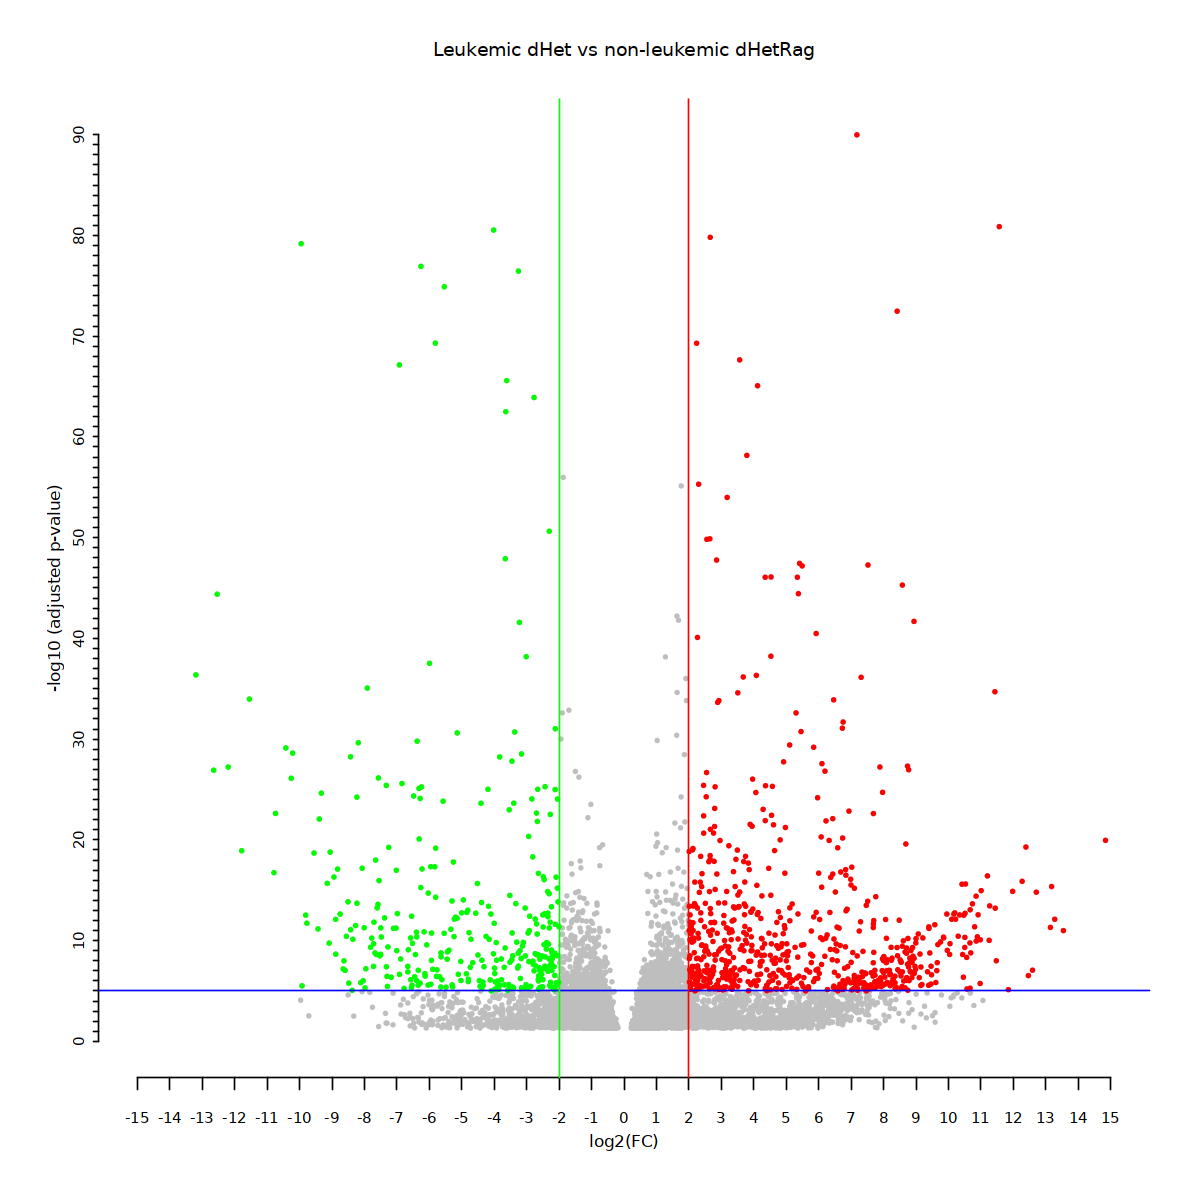

In [76]:
## Code cell 76 ##

options(repr.plot.width = 10, repr.plot.height = 10)

#draw the plot
plot(-log10(res2_dHet_dHetRag_sig_ranked_annot$padj) ~ res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange, pch = "", xlim = c(-15,15), ylim = c(0,90),
     xlab = "",ylab = "", bty = "n", xaxt = "n", yaxt = "n"  )
title("Leukemic dHet vs non-leukemic dHetRag", font.main = 1, cex.main = 0.9)
axis(1, at = -15:15, tcl = -0.5,cex = 0.7, labels = F )
mtext(-15:15,side = 1,line = 1,at = -15:15, cex = 0.7)
axis(2, at = 0:90, tcl = -0.2, cex = 0.7, labels = F )
mtext(seq(0,90,10),side = 2,line = 0.5, at = seq(0,90,10), cex = 0.7)


## Color in grey genes
points(-log10(res2_dHet_dHetRag_sig_ranked_annot$padj) ~ res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange, pch = 16, cex = 0.5, col = "grey")


## Override the previous colouring for some genes according to the fact they are DE
points(-log10(upGenes$padj) ~ upGenes$log2FoldChange,pch = 16, cex = 0.5, col = "red")
points(-log10(downGenes$padj) ~ downGenes$log2FoldChange, pch = 16,cex = 0.5, col = "green")
mtext("log2(FC)", side = 1, line = 2, cex = 0.8)
mtext("-log10 (adjusted p-value)", side = 2, line = 1.5, cex = 0.8)

abline(h=-log10(alpha), col="blue")
abline(v=-2, col="green")
abline(v=2, col="red")

* **Enlarging the volcano plot** 

As we can see in the list of DE genes ranked by p-value: 

In [77]:
## Code cell 77 ##

head(res2_dHet_dHetRag_sig_ranked_annot, n = 3)

,ensemblID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000117613.3,3233.188,7.619955,0.3028339,25.16216,1.040198e-139,2.289997e-135,chr18,HAVANA,15327780,15409293,+,lncRNA,Gm2629,level 2,MGI:3780797,OTTMUSG00000072880.1
2,ENSMUSG00000024241.8,11366.422,5.028573,0.2069752,24.29553,2.185695e-130,2.405904e-126,chr17,HAVANA,80701180,80787882,-,protein_coding,Sos1,level 2,MGI:98354,OTTMUSG00000072682.1
3,ENSMUSG00000070348.6,10921.858,7.178419,0.3479313,20.63172,1.424977e-94,1.045695e-90,chr7,HAVANA,144483668,144493662,-,protein_coding,Ccnd1,level 2,MGI:88313,OTTMUSG00000026018.2


the top DE genes have *very very* low adjusted p-value, that were not displayed in this first volcano plot.    

So in the cell below, we change the ylim and the ranges for the y axis to accomodate these high values.    
We also change 
- the size of colored points: `cex = 0.7` instead of `cex = 0.5`
- the lettering size for the main title: `cex.main = 1.5` instead of `cex.main = 0.9`
- and for the axis titles: `cex = 1` instead of `cex = 0.8`   
- the colors of points and lines to accomodate colorblind viewers. 

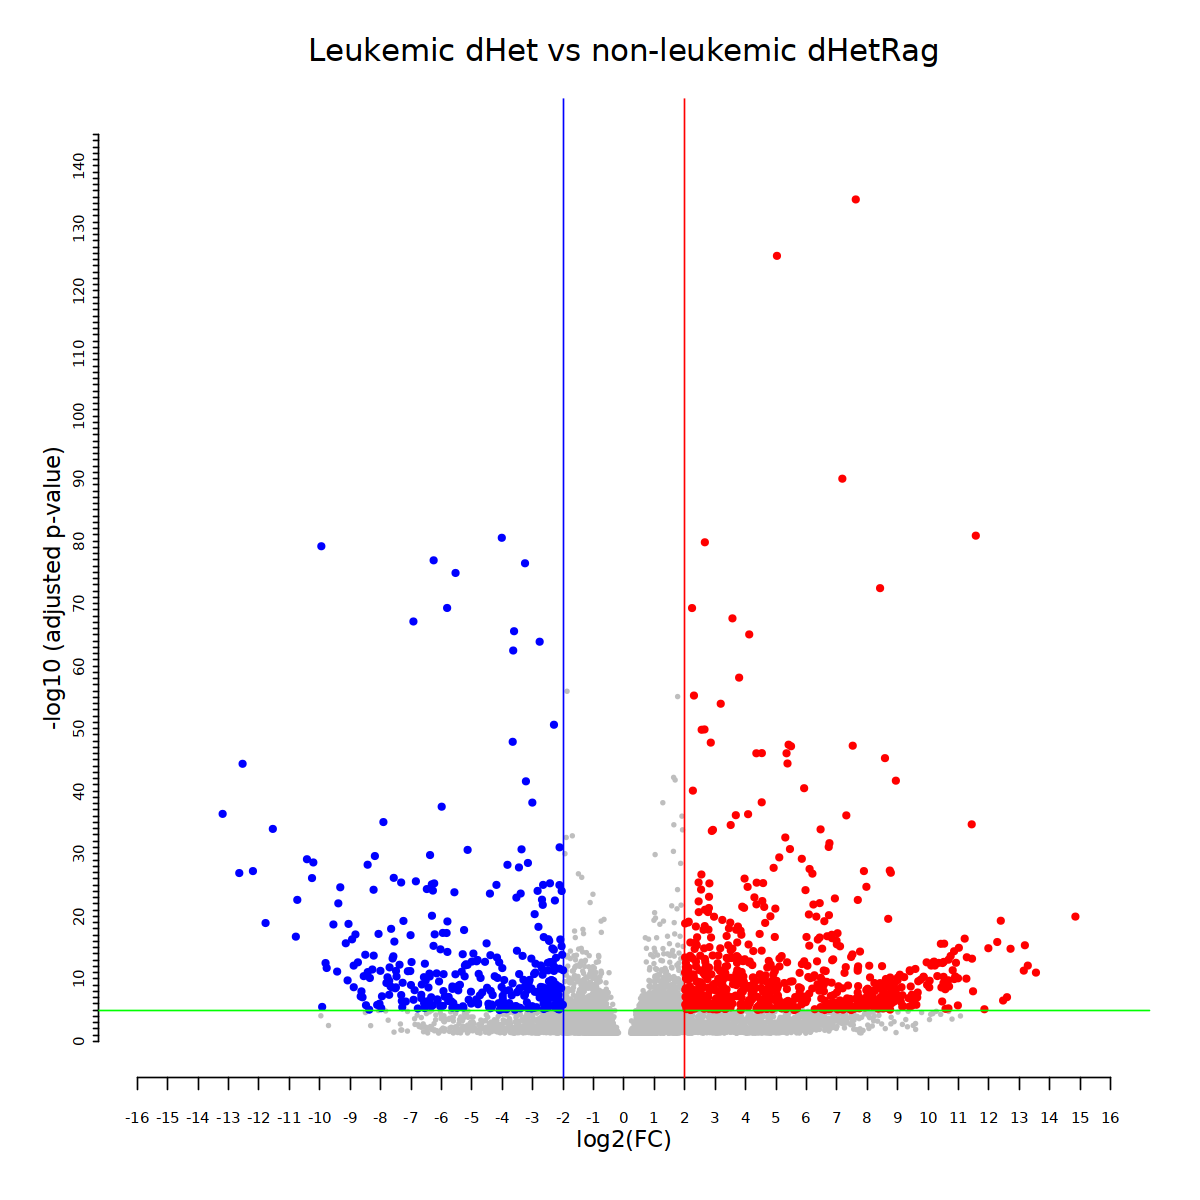

In [78]:
## Code cell 78 ##

options(repr.plot.width = 10, repr.plot.height = 10)

#draw the plot
plot(-log10(res2_dHet_dHetRag_sig_ranked_annot$padj) ~ res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange, pch = "", xlim = c(-16,16), ylim = c(0,145),
     xlab = "",ylab = "", bty = "n", xaxt = "n", yaxt = "n"  )
title("Leukemic dHet vs non-leukemic dHetRag", font.main = 1, cex.main = 1.5)
axis(1, at = -16:16, tcl = -0.5,cex = 0.7, labels = F )
mtext(-16:16,side = 1,line = 1,at = -16:16, cex = 0.7)
axis(2, at = 0:145, tcl = -0.2, cex = 0.7, labels = F )
mtext(seq(0,145,10),side = 2,line = 0.5, at = seq(0,145,10), cex = 0.7)


## Color in grey genes
points(-log10(res2_dHet_dHetRag_sig_ranked_annot$padj) ~ res2_dHet_dHetRag_sig_ranked_annot$log2FoldChange, pch = 16, cex = 0.5, col = "grey")


## Override the previous colouring for some genes according to the fact they are DE
points(-log10(upGenes$padj) ~ upGenes$log2FoldChange,pch = 16, cex = 0.8, col = "red")
points(-log10(downGenes$padj) ~ downGenes$log2FoldChange, pch = 16,cex = 0.8, col = "blue")
mtext("log2(FC)", side = 1, line = 2, cex = 1.1)
mtext("-log10 (adjusted p-value)", side = 2, line = 1.5, cex = 1.1)

abline(h=-log10(alpha), col="green")
abline(v=-2, col="blue")
abline(v=2, col="red")

___
---
## 6 - Saving our results for later use: DE genes lists and RData file
---

### 6.1 - DE genes lists    
---

As we have selected DE genes on the basis of their adjusted p-value and their log2 Fold change, we can save those list for further enrichment analysis. We write the differentially expressed gene lists to tabulated txt files, in the deseq2folder that we decided at first.  

In [79]:
## Code cell 79 ##

dim(upGenes)
dim(downGenes)
head(upGenes)

[1] 698  17

[1] 335  17

,ensemblID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000117613.3,3233.188,7.619955,0.3028339,25.16216,1.040198e-139,2.289997e-135,chr18,HAVANA,15327780,15409293,+,lncRNA,Gm2629,level 2,MGI:3780797,OTTMUSG00000072880.1
2,ENSMUSG00000024241.8,11366.422,5.028573,0.2069752,24.29553,2.185695e-130,2.405904e-126,chr17,HAVANA,80701180,80787882,-,protein_coding,Sos1,level 2,MGI:98354,OTTMUSG00000072682.1
3,ENSMUSG00000070348.6,10921.858,7.178419,0.3479313,20.63172,1.424977e-94,1.045695e-90,chr7,HAVANA,144483668,144493662,-,protein_coding,Ccnd1,level 2,MGI:88313,OTTMUSG00000026018.2
4,ENSMUSG00000021423.7,5928.381,11.566314,0.5908234,19.57660,2.448278e-85,1.347471e-81,chr13,HAVANA,37529184,37603012,+,protein_coding,Ly86,level 2,MGI:1321404,OTTMUSG00000068199.1
6,ENSMUSG00000025232.9,3409.044,2.658209,0.1368027,19.43097,4.223195e-84,1.549561e-80,chr9,HAVANA,59446823,59472392,+,protein_coding,Hexa,level 2,MGI:96073,OTTMUSG00000063295.1
11,ENSMUSG00000022836.12,1946.976,8.419124,0.4548085,18.51136,1.672240e-76,3.346760e-73,chr16,HAVANA,34565580,34822790,+,protein_coding,Mylk,level 2,MGI:894806,OTTMUSG00000017049.2


We save those 2 lists in our Results/deseq2 folder:

In [80]:
## Code cell 80 ##

write.table(upGenes$gene_name, file=paste0(deseq2folder,"DESeq2_significant_genes-0_00001-up.tsv"), sep="\t", quote=F, col.names=TRUE, row.names = FALSE)
write.table(downGenes$gene_name, file=paste0(deseq2folder,"DESeq2_significant_genes-0_00001-down.tsv"), sep="\t", quote=F, col.names=TRUE, row.names = FALSE)


### 6.2 - RData object for the session
---

We can save all relevant R objects created in this session in a single R object.   
This will help us to reload our results without having to run the same commands.   

In [81]:
## Code cell 81 ##

print(ls())

 [1] "alpha"                              "conditionColor"                    
 [3] "countdata"                          "counts.rlog.dds2"                  
 [5] "counts.vst.dds2"                    "dHet_dHetRag"                      
 [7] "dds"                                "dds2"                              
 [9] "deseq2folder"                       "df"                                
[11] "downGenes"                          "gencode"                           
[13] "gohome"                             "lvls"                              
[15] "myfolder"                           "rdata"                             
[17] "res2_dHet_dHetRag"                  "res2_dHet_dHetRag_sig_genes"       
[19] "res2_dHet_dHetRag_sig_ranked"       "res2_dHet_dHetRag_sig_ranked_annot"
[21] "resTot_dHet_dHetRag"                "res_dHet_dHetRag"                  
[23] "res_dHet_dHetRag_annot"             "rlog.dds2"                         
[25] "rlog.dds2.annot"                    "samples" 

and we save our info in a single RData object in our output folder:

In [82]:
## Code cell 82 ##

save(rlog.dds2.annot, res2_dHet_dHetRag_sig_ranked_annot, gencode, samples, upGenes, downGenes, file = paste0(deseq2folder, "deseq2.RData"))

<span style="color:red"><b>For GSEA analysis, we also save `res_dHet_dHetRag_annot` in another object:</b></span>

In [83]:
## Code cell 83 ##

save(res_dHet_dHetRag_annot, file = paste0(deseq2folder, "deseq2_all_genes.RData"))

---
___


Now we go on with the visualization of normalized read counts in a full exploratory analysis.  
  
**=> Step 10: Exploratory analysis of normalized data** 

The jupyter notebook used for the next session will be *Pipe_10-R-Normcounts-exploratory-analysis-II.ipynb*    
Let's retrieve it in our directory, in order to have a private copy to work on:   

In [85]:
## Code cell 84 ##   

myfolder
file.copy("/shared/projects/2413_rnaseq_cea/pipeline/Pipe_10-R-Normcounts-exploratory-analysis-II.ipynb", myfolder)


[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet"

[1] FALSE



**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks' folder. **Adjust the name with yours** and reformat as code cell to run it.

In [84]:
## Code cell 85 ##   

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste0(myfolder,"/run_notebooks"), recursive = TRUE, showWarnings = FALSE)

runfolder <- paste0(myfolder,"/run_notebooks")
       
file.copy(paste0(myfolder, "/Pipe_09-R-DESeq2-normalisation-DE.ipynb"), paste0(runfolder, "/Pipe_09-R-DESeq2-normalisation-DE-run.ipynb"))


[1] TRUE

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to perform a normalisation and a differential expression analysis using DESeq2.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

---
---

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Bénédicte Noblet - 05-07 2021   
Sandrine Caburet et Claire Vandiedonck - 02-06 2023   
with adaptations from https://bioinformatics-core-shared-training.github.io/RNAseq_November_2020_remote/html/02_Preprocessing_Data.html, https://rpubs.com/adoughan/778146 , https://github.com/hbctraining/DGE_workshop_salmon_online/tree/master/lessons, https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog and  https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#the-deseqdataset

Maj 22/06/2024 par @SCaburet